# Task 3: CLIP


In [ ]:
!pip install git+https://github.com/openai/CLIP.git


  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-vi2vj_97
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-vi2vj_97
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 4.0 MB/s eta 0:00:00
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369490 sha256=785b233c642963c629a1eec52c08f6137996bd73c5b16d015c6d0f4721e0dcdb
  Stored in directory: /tmp/pip-ephem-wheel-cache-aaswpmsn/wheels/35/3e/df/3d24cbfb3b6a06f17a2bfd7d1138900d4365d9028aa8f6e92f
Successfully built clip


In [ ]:
from sklearn.model_selection import train_test_split
from torchvision import transforms, models
from torch.utils.data import Subset
from collections import Counter
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.optim import SGD
import torch.optim as optim
from tqdm import tqdm
import torch.nn as nn
import numpy as np
import torchvision
import torch
import os


## Loading PACS

In [ ]:
if not os.path.isdir('./Homework3-PACS'):
    !git clone https://github.com/MachineLearning2020/Homework3-PACS

means, stds = (0.485, 0.456, 0.406), (0.229, 0.224, 0.225)

transf = transforms.Compose([
                              transforms.CenterCrop(224),
                              transforms.ToTensor(),
                              transforms.Normalize(means,stds)
])

DIR_PHOTO = 'Homework3-PACS/PACS/photo'
DIR_ART = 'Homework3-PACS/PACS/art_painting'
DIR_CARTOON = 'Homework3-PACS/PACS/cartoon'
DIR_SKETCH = 'Homework3-PACS/PACS/sketch'

photo_dataset = torchvision.datasets.ImageFolder(DIR_PHOTO, transform=transf)
art_dataset = torchvision.datasets.ImageFolder(DIR_ART, transform=transf)
cartoon_dataset = torchvision.datasets.ImageFolder(DIR_CARTOON, transform=transf)
sketch_dataset = torchvision.datasets.ImageFolder(DIR_SKETCH, transform=transf)

domains = {
    'photo': photo_dataset,
    'art_painting': art_dataset,
    'cartoon': cartoon_dataset,
    'sketch': sketch_dataset
}

Cloning into 'Homework3-PACS'...
remote: Enumerating objects: 10032, done.
remote: Total 10032 (delta 0), reused 0 (delta 0), pack-reused 10032 (from 1)
Receiving objects: 100% (10032/10032), 174.13 MiB | 21.75 MiB/s, done.
Resolving deltas: 100% (1/1), done.
Updating files: 100% (9993/9993), done.


### Visualization

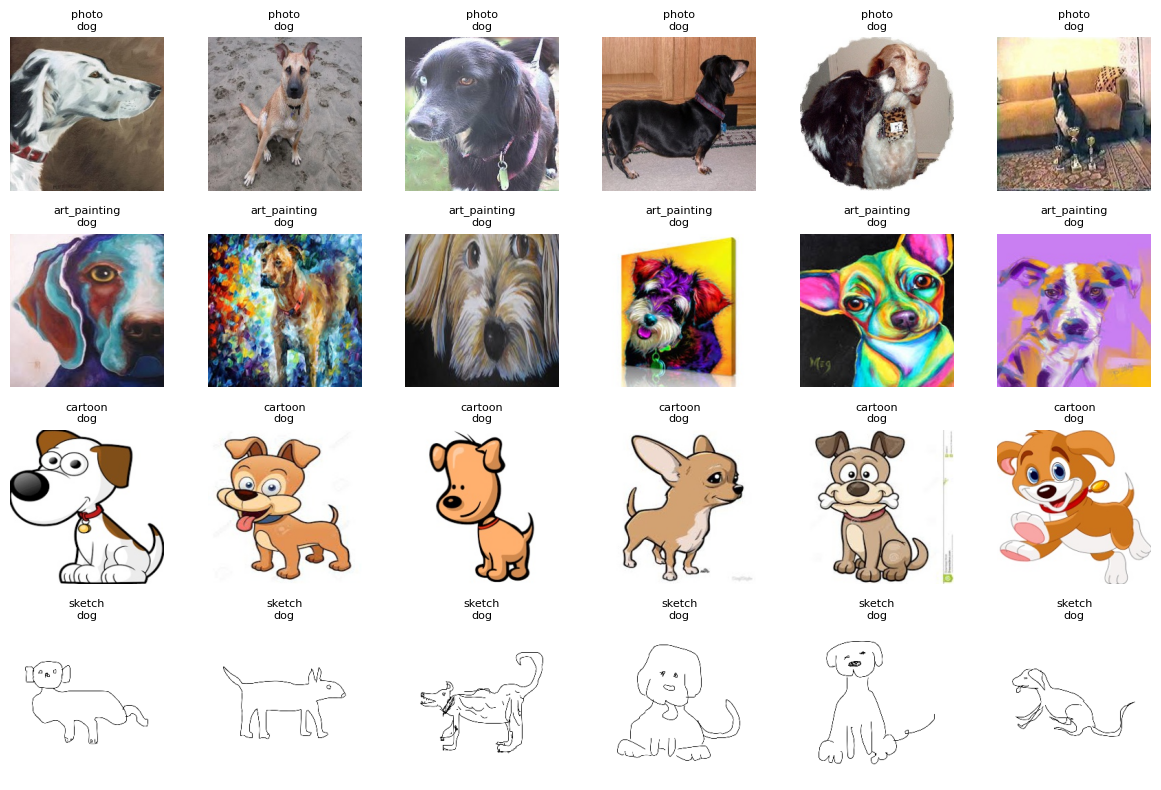

In [ ]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(4, 6, figsize=(12, 8))
for i, (name, dataset) in enumerate(domains.items()):
    for j in range(6):
        img, label = dataset[j]
        img = img.permute(1, 2, 0) * torch.tensor([0.229, 0.224, 0.225]) + torch.tensor([0.485, 0.456, 0.406])
        img = img.clamp(0, 1)
        axes[i, j].imshow(img)
        axes[i, j].set_title(f"{name}\n{dataset.classes[label]}", fontsize=8)
        axes[i, j].axis("off")

plt.tight_layout()
plt.show()


📁 Domain: photo
  dog        :  189 images
  elephant   :  202 images
  giraffe    :  182 images
  guitar     :  186 images
  horse      :  199 images
  house      :  280 images
  person     :  432 images

📁 Domain: art_painting
  dog        :  379 images
  elephant   :  255 images
  giraffe    :  285 images
  guitar     :  184 images
  horse      :  201 images
  house      :  295 images
  person     :  449 images

📁 Domain: cartoon
  dog        :  389 images
  elephant   :  457 images
  giraffe    :  346 images
  guitar     :  135 images
  horse      :  324 images
  house      :  288 images
  person     :  405 images

📁 Domain: sketch
  dog        :  772 images
  elephant   :  740 images
  giraffe    :  753 images
  guitar     :  608 images
  horse      :  816 images
  house      :   80 images
  person     :  160 images


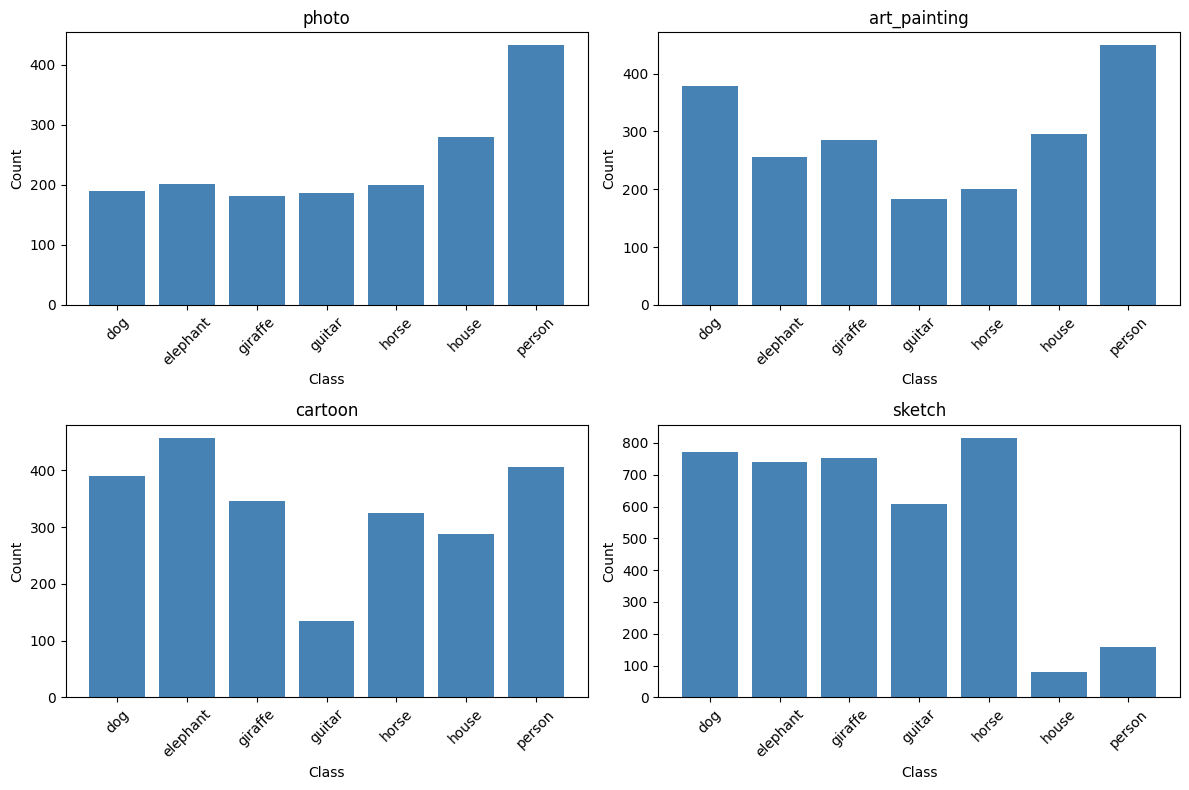

In [ ]:
for domain_name, dataset in domains.items():
    class_counts = Counter([label for _, label in dataset.samples])
    class_counts = dict(sorted(class_counts.items()))

    print(f"\n📁 Domain: {domain_name}")
    for i, cls_name in enumerate(dataset.classes):
        print(f"  {cls_name:10s} : {class_counts[i]:4d} images")

fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes = axes.flatten()

for i, (domain_name, dataset) in enumerate(domains.items()):
    class_counts = Counter([label for _, label in dataset.samples])
    class_counts = dict(sorted(class_counts.items()))
    counts = [class_counts[i] for i in range(len(dataset.classes))]

    axes[i].bar(dataset.classes, counts, color='steelblue')
    axes[i].set_title(domain_name)
    axes[i].set_xlabel('Class')
    axes[i].set_ylabel('Count')
    axes[i].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


### Initialization

In [ ]:
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Subset
from torchvision import datasets


def make_loaders(dataset, dir_path, test_size=0.2, seed=42, batch_size=32):
    labels = np.array([s[1] for s in dataset.samples])
    train_idx, test_idx = train_test_split(
        np.arange(len(labels)),
        test_size=test_size,
        random_state=seed,
        stratify=labels
    )

    train_set = Subset(dataset, train_idx)
    test_set = Subset(datasets.ImageFolder(dir_path, transform=transf), test_idx)

    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, drop_last=True)
    test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

    return train_set, test_set, train_loader, test_loader

art_train, art_test, art_train_loader, art_test_loader = make_loaders(art_dataset, DIR_ART)
cartoon_train, cartoon_test, cartoon_train_loader, cartoon_test_loader = make_loaders(cartoon_dataset, DIR_CARTOON)
photo_train, photo_test, photo_train_loader, photo_test_loader = make_loaders(photo_dataset, DIR_PHOTO)
sketch_train, sketch_test, sketch_train_loader, sketch_test_loader = make_loaders(sketch_dataset, DIR_SKETCH)

print("\n====== PACS Dataset Summary ======")
print(f"Art total:     {len(art_dataset)}, train: {len(art_train)}, test: {len(art_test)}")
print(f"Cartoon total: {len(cartoon_dataset)}, train: {len(cartoon_train)}, test: {len(cartoon_test)}")
print(f"Photo total:   {len(photo_dataset)}, train: {len(photo_train)}, test: {len(photo_test)}")
print(f"Sketch total:  {len(sketch_dataset)}, train: {len(sketch_train)}, test: {len(sketch_test)}")

print("\nDataloaders ready:")
print(f"  - Art train batches:     {len(art_train_loader)}")
print(f"  - Art test batches:      {len(art_test_loader)}")
print(f"  - Cartoon train batches: {len(cartoon_train_loader)}")
print(f"  - Cartoon test batches:  {len(cartoon_test_loader)}")
print(f"  - Photo train batches:   {len(photo_train_loader)}")
print(f"  - Photo test batches:    {len(photo_test_loader)}")
print(f"  - Sketch train batches:  {len(sketch_train_loader)}")
print(f"  - Sketch test batches:   {len(sketch_test_loader)}")

domain_loaders = {
    'art_painting': {'train': art_train_loader, 'test': art_test_loader},
    'cartoon': {'train': cartoon_train_loader, 'test': cartoon_test_loader},
    'photo': {'train': photo_train_loader, 'test': photo_test_loader},
    'sketch': {'train': sketch_train_loader, 'test': sketch_test_loader}
}




====== PACS Dataset Summary ======
Art total:     2048, train: 1638, test: 410
Cartoon total: 2344, train: 1875, test: 469
Photo total:   1670, train: 1336, test: 334
Sketch total:  3929, train: 3143, test: 786

Dataloaders ready:
  - Art train batches:     51
  - Art test batches:      13
  - Cartoon train batches: 58
  - Cartoon test batches:  15
  - Photo train batches:   41
  - Photo test batches:    11
  - Sketch train batches:  98
  - Sketch test batches:   25


## Task 3.1: Source-Only Baseline

In [ ]:
import clip

device = "cuda" if torch.cuda.is_available() else "cpu"

model, preprocess = clip.load("ViT-B/32", device=device)
model.eval()

classnames = photo_dataset.classes
print("\nClasses:", classnames)

prompt_templates = {
    "photo": "a photo of a {}",
    "art_painting": "a painting of a {}",
    "cartoon": "a cartoon of a {}",
    "sketch": "a sketch of a {}"
}

def build_text_features(domain_name):
    """Generate text embeddings for the given domain's prompt."""
    prompts = [prompt_templates[domain_name].format(c.replace("_", " ")) for c in classnames]
    text_tokens = clip.tokenize(prompts).to(device)
    with torch.no_grad():
        text_features = model.encode_text(text_tokens)
        text_features /= text_features.norm(dim=-1, keepdim=True)
    return text_features

@torch.no_grad()
def evaluate_zero_shot(domain_name, loader, text_features):
    correct, total = 0, 0
    for images, labels in tqdm(loader, desc=f"Evaluating {domain_name}"):
        images, labels = images.to(device), labels.to(device)
        image_features = model.encode_image(images)
        image_features /= image_features.norm(dim=-1, keepdim=True)

        logits = 100.0 * image_features @ text_features.T
        preds = logits.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    acc = correct / total * 100
    return acc

#  RUN EVALUATION

results = {}
for domain_name, loaders in domain_loaders.items():
    print(f"\n--- Zero-Shot CLIP on {domain_name.upper()} ---")
    text_features = build_text_features(domain_name)
    acc = evaluate_zero_shot(domain_name, loaders['test'], text_features)
    results[domain_name] = acc
    print(f"{domain_name.capitalize()} Accuracy: {acc:.2f}%")

print("\n====== Final CLIP Zero-Shot Results (PACS) ======")
for domain_name, acc in results.items():
    print(f"{domain_name.capitalize():<15}: {acc:.2f}%")
print(f"Average Accuracy: {np.mean(list(results.values())):.2f}%")


100%|███████████████████████████████████████| 338M/338M [00:04<00:00, 76.5MiB/s]



Classes: ['dog', 'elephant', 'giraffe', 'guitar', 'horse', 'house', 'person']

--- Zero-Shot CLIP on ART_PAINTING ---


Evaluating art_painting: 100%|██████████| 13/13 [00:01<00:00,  6.63it/s]


Art_painting Accuracy: 94.39%

--- Zero-Shot CLIP on CARTOON ---


Evaluating cartoon: 100%|██████████| 15/15 [00:01<00:00, 11.39it/s]


Cartoon Accuracy: 97.65%

--- Zero-Shot CLIP on PHOTO ---


Evaluating photo: 100%|██████████| 11/11 [00:00<00:00, 12.55it/s]


Photo Accuracy: 100.00%

--- Zero-Shot CLIP on SKETCH ---


Evaluating sketch: 100%|██████████| 25/25 [00:02<00:00, 12.12it/s]

Sketch Accuracy: 83.72%

====== Final CLIP Zero-Shot Results (PACS) ======
Art_painting   : 94.39%
Cartoon        : 97.65%
Photo          : 100.00%
Sketch         : 83.72%
Average Accuracy: 93.94%


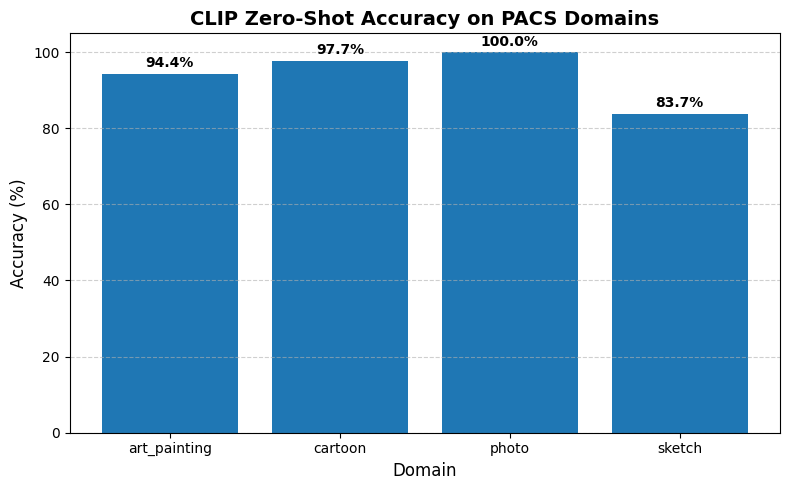

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming 'results' dict from your zero-shot run exists
domains = list(results.keys())
accuracies = [results[d] for d in domains]

plt.figure(figsize=(8,5))
bars = plt.bar(domains, accuracies)
plt.title("CLIP Zero-Shot Accuracy on PACS Domains", fontsize=14, weight='bold')
plt.xlabel("Domain", fontsize=12)
plt.ylabel("Accuracy (%)", fontsize=12)

# Annotate bars with accuracy values
for bar, acc in zip(bars, accuracies):
    plt.text(bar.get_x() + bar.get_width()/2, acc + 1, f"{acc:.1f}%",
             ha='center', va='bottom', fontsize=10, weight='bold')

plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

In [ ]:
source_domains = ['art_painting', 'cartoon', 'photo']
target_domain = 'sketch'

num_classes = len(photo_dataset.classes)
feature_dim = model.visual.output_dim

@torch.no_grad()
def extract_features(loader):
    feats, labels = [], []
    for imgs, lbls in tqdm(loader, leave=False):
        imgs = imgs.to(device)
        with torch.no_grad():
            emb = model.encode_image(imgs)
            emb = emb / emb.norm(dim=-1, keepdim=True)
            emb = emb.float()
        feats.append(emb.cpu())
        labels.append(lbls)
    return torch.cat(feats), torch.cat(labels)

X_src, y_src = [], []
for domain in source_domains:
    print(f"Extracting features from {domain} (source)")
    feats, labels = extract_features(domain_loaders[domain]['train'])
    X_src.append(feats)
    y_src.append(labels)

X_src = torch.cat(X_src)
y_src = torch.cat(y_src)

print(f"\nSource features: {X_src.shape}, labels: {y_src.shape}")

print(f"\nExtracting features from {target_domain} (target)")
X_tgt, y_tgt = extract_features(domain_loaders[target_domain]['test'])
print(f"Target features: {X_tgt.shape}, labels: {y_tgt.shape}")

classifier = nn.Linear(feature_dim, num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(classifier.parameters(), lr=1e-3, weight_decay=1e-4)

epochs = 10
classifier.train()
for epoch in range(epochs):
    perm = torch.randperm(len(X_src))
    X_src_epoch, y_src_epoch = X_src[perm], y_src[perm]
    total_loss = 0
    for i in range(0, len(X_src_epoch), 64):
        xb = X_src_epoch[i:i+64].to(device)
        yb = y_src_epoch[i:i+64].to(device)

        optimizer.zero_grad()
        preds = classifier(xb)
        loss = criterion(preds, yb)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * len(xb)

    avg_loss = total_loss / len(X_src)
    print(f"Epoch [{epoch+1}/{epochs}]  Loss: {avg_loss:.4f}")

Extracting features from art_painting (source)


Extracting features from cartoon (source)


Extracting features from photo (source)



Source features: torch.Size([4800, 512]), labels: torch.Size([4800])

Extracting features from sketch (target)


Target features: torch.Size([786, 512]), labels: torch.Size([786])
Epoch [1/10]  Loss: 1.7874
Epoch [2/10]  Loss: 1.4994
Epoch [3/10]  Loss: 1.2590
Epoch [4/10]  Loss: 1.0609
Epoch [5/10]  Loss: 0.9003
Epoch [6/10]  Loss: 0.7717
Epoch [7/10]  Loss: 0.6690
Epoch [8/10]  Loss: 0.5866
Epoch [9/10]  Loss: 0.5201
Epoch [10/10]  Loss: 0.4657


In [ ]:
classifier.eval()
results2 = {}

with torch.no_grad():
    for domain_name, loaders in domain_loaders.items():
        X_eval, y_eval = extract_features(loaders['test'])
        preds = classifier(X_eval.to(device))
        acc = (preds.argmax(dim=1).cpu() == y_eval).float().mean().item() * 100
        results2[domain_name] = acc
        print(f"{domain_name.capitalize()} Test Accuracy: {acc:.2f}%")

print("\n====== CLIP Linear Probe Results (All Domains) ======")
for domain_name, acc in results2.items():
    print(f"{domain_name.capitalize():<15}: {acc:.2f}%")
print(f"Average Accuracy: {np.mean(list(results.values())):.2f}%")

Art_painting Test Accuracy: 95.61%


Cartoon Test Accuracy: 99.36%


Photo Test Accuracy: 100.00%


Sketch Test Accuracy: 85.62%

====== CLIP Linear Probe Results (All Domains) ======
Art_painting   : 95.61%
Cartoon        : 99.36%
Photo          : 100.00%
Sketch         : 85.62%
Average Accuracy: 93.94%


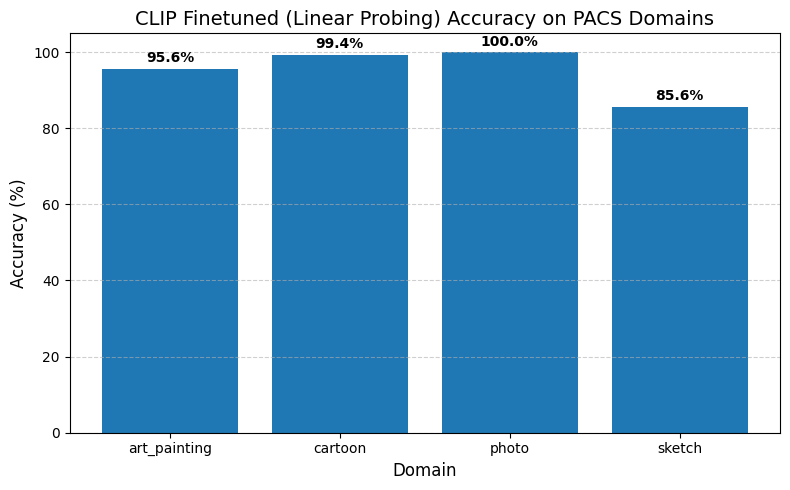

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

domains = list(results2.keys())
accuracies = [results2[d] for d in domains]

plt.figure(figsize=(8,5))
bars = plt.bar(domains, accuracies)
plt.title("CLIP Finetuned (Linear Probing) Accuracy on PACS Domains", fontsize=14)
plt.xlabel("Domain", fontsize=12)
plt.ylabel("Accuracy (%)", fontsize=12)

for bar, acc in zip(bars, accuracies):
    plt.text(bar.get_x() + bar.get_width()/2, acc + 1, f"{acc:.1f}%",
             ha='center', va='bottom', fontsize=10, weight='bold')

plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

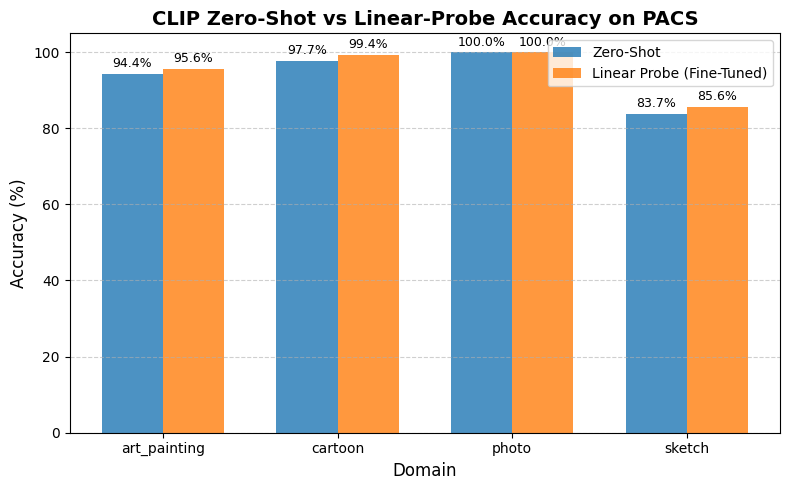

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

domains = list(results.keys())
x = np.arange(len(domains))
width = 0.35

zero_shot = [results[d] for d in domains]
linear_probe = [results2[d] for d in domains]

plt.figure(figsize=(8,5))
plt.bar(x - width/2, zero_shot, width, label='Zero-Shot', alpha=0.8)
plt.bar(x + width/2, linear_probe, width, label='Linear Probe (Fine-Tuned)', alpha=0.8)

plt.title("CLIP Zero-Shot vs Linear-Probe Accuracy on PACS", fontsize=14, weight='bold')
plt.xlabel("Domain", fontsize=12)
plt.ylabel("Accuracy (%)", fontsize=12)
plt.xticks(x, domains)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.6)

# annotate values
for i, (zs, lp) in enumerate(zip(zero_shot, linear_probe)):
    plt.text(i - width/2, zs + 1, f"{zs:.1f}%", ha='center', va='bottom', fontsize=9)
    plt.text(i + width/2, lp + 1, f"{lp:.1f}%", ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()


### Testing a different source domain


In [ ]:
source_domains = ['art_painting', 'sketch', 'photo']
target_domain = 'cartoon'

num_classes = len(photo_dataset.classes)
feature_dim = model.visual.output_dim

@torch.no_grad()
def extract_features(loader):
    feats, labels = [], []
    for imgs, lbls in tqdm(loader, leave=False):
        imgs = imgs.to(device)
        with torch.no_grad():
            emb = model.encode_image(imgs)
            emb = emb / emb.norm(dim=-1, keepdim=True)
            emb = emb.float()
        feats.append(emb.cpu())
        labels.append(lbls)
    return torch.cat(feats), torch.cat(labels)

X_src, y_src = [], []
for domain in source_domains:
    print(f"Extracting features from {domain} (source)")
    feats, labels = extract_features(domain_loaders[domain]['train'])
    X_src.append(feats)
    y_src.append(labels)

X_src = torch.cat(X_src)
y_src = torch.cat(y_src)

print(f"\nSource features: {X_src.shape}, labels: {y_src.shape}")

print(f"\nExtracting features from {target_domain} (target)")
X_tgt, y_tgt = extract_features(domain_loaders[target_domain]['test'])
print(f"Target features: {X_tgt.shape}, labels: {y_tgt.shape}")

classifier = nn.Linear(feature_dim, num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(classifier.parameters(), lr=1e-3, weight_decay=1e-4)

epochs = 10
classifier.train()
for epoch in range(epochs):
    perm = torch.randperm(len(X_src))
    X_src_epoch, y_src_epoch = X_src[perm], y_src[perm]
    total_loss = 0
    for i in range(0, len(X_src_epoch), 64):
        xb = X_src_epoch[i:i+64].to(device)
        yb = y_src_epoch[i:i+64].to(device)

        optimizer.zero_grad()
        preds = classifier(xb)
        loss = criterion(preds, yb)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * len(xb)

    avg_loss = total_loss / len(X_src)
    print(f"Epoch [{epoch+1}/{epochs}]  Loss: {avg_loss:.4f}")

Extracting features from art_painting (source)


Extracting features from sketch (source)


Extracting features from photo (source)



Source features: torch.Size([6080, 512]), labels: torch.Size([6080])

Extracting features from cartoon (target)


Target features: torch.Size([469, 512]), labels: torch.Size([469])
Epoch [1/10]  Loss: 1.7557
Epoch [2/10]  Loss: 1.4358
Epoch [3/10]  Loss: 1.1877
Epoch [4/10]  Loss: 0.9950
Epoch [5/10]  Loss: 0.8474
Epoch [6/10]  Loss: 0.7349
Epoch [7/10]  Loss: 0.6479
Epoch [8/10]  Loss: 0.5796
Epoch [9/10]  Loss: 0.5253
Epoch [10/10]  Loss: 0.4813


In [ ]:
classifier.eval()
results3 = {}

with torch.no_grad():
    for domain_name, loaders in domain_loaders.items():
        X_eval, y_eval = extract_features(loaders['test'])
        preds = classifier(X_eval.to(device))
        acc = (preds.argmax(dim=1).cpu() == y_eval).float().mean().item() * 100
        results3[domain_name] = acc
        print(f"{domain_name.capitalize()} Test Accuracy: {acc:.2f}%")

print("\n====== CLIP Linear Probe Results (All Domains) ======")
for domain_name, acc in results3.items():
    print(f"{domain_name.capitalize():<15}: {acc:.2f}%")
print(f"Average Accuracy: {np.mean(list(results3.values())):.2f}%")

Art_painting Test Accuracy: 95.37%


Cartoon Test Accuracy: 97.65%


Photo Test Accuracy: 99.70%


Sketch Test Accuracy: 90.46%

====== CLIP Linear Probe Results (All Domains) ======
Art_painting   : 95.37%
Cartoon        : 97.65%
Photo          : 99.70%
Sketch         : 90.46%
Average Accuracy: 95.79%


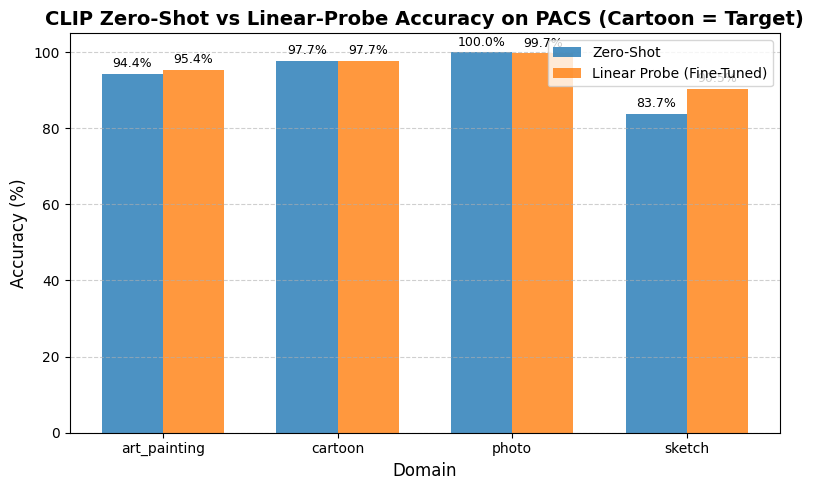

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

domains = list(results.keys())
x = np.arange(len(domains))
width = 0.35

zero_shot = [results[d] for d in domains]
linear_probe = [results3[d] for d in domains]

plt.figure(figsize=(8,5))
plt.bar(x - width/2, zero_shot, width, label='Zero-Shot', alpha=0.8)
plt.bar(x + width/2, linear_probe, width, label='Linear Probe (Fine-Tuned)', alpha=0.8)

plt.title("CLIP Zero-Shot vs Linear-Probe Accuracy on PACS (Cartoon = Target)", fontsize=14, weight='bold')
plt.xlabel("Domain", fontsize=12)
plt.ylabel("Accuracy (%)", fontsize=12)
plt.xticks(x, domains)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.6)

# annotate values
for i, (zs, lp) in enumerate(zip(zero_shot, linear_probe)):
    plt.text(i - width/2, zs + 1, f"{zs:.1f}%", ha='center', va='bottom', fontsize=9)
    plt.text(i + width/2, lp + 1, f"{lp:.1f}%", ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()


## Task 3.2: Context Optimization (CoOp)


In [ ]:
import torch
import torch.nn as nn
from torch.nn import functional as F
import clip
from clip.simple_tokenizer import SimpleTokenizer as _Tokenizer
from tqdm import tqdm
import numpy as np

_tokenizer = _Tokenizer()

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Device: {device}")

class_names = ['dog', 'elephant', 'giraffe', 'guitar', 'horse', 'house', 'person']
print(f"Classes: {class_names}")

Device: cuda
Classes: ['dog', 'elephant', 'giraffe', 'guitar', 'horse', 'house', 'person']


In [ ]:
class TextEncoder(nn.Module):
    def __init__(self, clip_model):
        super().__init__()
        self.transformer = clip_model.transformer
        self.positional_embedding = clip_model.positional_embedding
        self.ln_final = clip_model.ln_final
        self.text_projection = clip_model.text_projection
        self.dtype = clip_model.dtype

    def forward(self, prompts, tokenized_prompts):
        x = prompts + self.positional_embedding.type(self.dtype)
        x = x.permute(1, 0, 2)  # NLD -> LND
        x = self.transformer(x)
        x = x.permute(1, 0, 2)  # LND -> NLD
        x = self.ln_final(x).type(self.dtype)

        x = x[torch.arange(x.shape[0]), tokenized_prompts.argmax(dim=-1)] @ self.text_projection

        return x


class PromptLearner(nn.Module):
    def __init__(self, classnames, clip_model, n_ctx=16, ctx_init=None, class_token_position="end"):
        super().__init__()
        n_cls = len(classnames)
        dtype = clip_model.dtype
        ctx_dim = clip_model.ln_final.weight.shape[0]

        # Determine device from clip_model
        self.device = next(clip_model.parameters()).device

        if ctx_init:
            # use given words to initialize context vectors
            ctx_init = ctx_init.replace("_", " ")
            n_ctx = len(ctx_init.split(" "))
            prompt = clip.tokenize(ctx_init).to(self.device)
            with torch.no_grad():
                embedding = clip_model.token_embedding(prompt).type(dtype)
            ctx_vectors = embedding[0, 1 : 1 + n_ctx, :]
            prompt_prefix = ctx_init
        else:
            # random initialization
            ctx_vectors = torch.empty(n_ctx, ctx_dim, dtype=dtype)
            nn.init.normal_(ctx_vectors, std=0.02)
            prompt_prefix = " ".join(["X"] * n_ctx)

        print(f'Initial context: "{prompt_prefix}"')
        print(f"Number of context words (tokens): {n_ctx}")

        self.ctx = nn.Parameter(ctx_vectors)

        classnames = [name.replace("_", " ") for name in classnames]
        name_lens = [len(_tokenizer.encode(name)) for name in classnames]
        prompts = [prompt_prefix + " " + name + "." for name in classnames]

        tokenized_prompts = torch.cat([clip.tokenize(p) for p in prompts]).to(self.device)
        with torch.no_grad():
            embedding = clip_model.token_embedding(tokenized_prompts).type(dtype)

        self.register_buffer("token_prefix", embedding[:, :1, :])  # SOS
        self.register_buffer("token_suffix", embedding[:, 1 + n_ctx :, :])  # CLS, EOS

        self.n_cls = n_cls
        self.n_ctx = n_ctx
        self.tokenized_prompts = tokenized_prompts  # torch.Tensor
        self.name_lens = name_lens
        self.class_token_position = class_token_position

    def forward(self):
        ctx = self.ctx
        if ctx.dim() == 2:
            ctx = ctx.unsqueeze(0).expand(self.n_cls, -1, -1)

        prefix = self.token_prefix
        suffix = self.token_suffix

        if self.class_token_position == "end":
            prompts = torch.cat(
                [
                    prefix,  # (n_cls, 1, dim)
                    ctx,     # (n_cls, n_ctx, dim)
                    suffix,  # (n_cls, *, dim)
                ],
                dim=1,
            )
        elif self.class_token_position == "middle":
            half_n_ctx = self.n_ctx // 2
            prompts = []
            for i in range(self.n_cls):
                name_len = self.name_lens[i]
                prefix_i = prefix[i : i + 1, :, :]
                class_i = suffix[i : i + 1, :name_len, :]
                suffix_i = suffix[i : i + 1, name_len:, :]
                ctx_i_half1 = ctx[i : i + 1, :half_n_ctx, :]
                ctx_i_half2 = ctx[i : i + 1, half_n_ctx:, :]
                prompt = torch.cat(
                    [
                        prefix_i,     # (1, 1, dim)
                        ctx_i_half1,  # (1, n_ctx//2, dim)
                        class_i,      # (1, name_len, dim)
                        ctx_i_half2,  # (1, n_ctx//2, dim)
                        suffix_i,     # (1, *, dim)
                    ],
                    dim=1,
                )
                prompts.append(prompt)
            prompts = torch.cat(prompts, dim=0)
        elif self.class_token_position == "front":
            prompts = []
            for i in range(self.n_cls):
                name_len = self.name_lens[i]
                prefix_i = prefix[i : i + 1, :, :]
                class_i = suffix[i : i + 1, :name_len, :]
                suffix_i = suffix[i : i + 1, name_len:, :]
                ctx_i = ctx[i : i + 1, :, :]
                prompt = torch.cat(
                    [
                        prefix_i,  # (1, 1, dim)
                        class_i,   # (1, name_len, dim)
                        ctx_i,     # (1, n_ctx, dim)
                        suffix_i,  # (1, *, dim)
                    ],
                    dim=1,
                )
                prompts.append(prompt)
            prompts = torch.cat(prompts, dim=0)
        else:
            raise ValueError

        return prompts


class CustomCLIP(nn.Module):
    def __init__(self, classnames, clip_model, n_ctx=16, ctx_init=None, class_token_position="end"):
        super().__init__()
        self.prompt_learner = PromptLearner(classnames, clip_model, n_ctx, ctx_init, class_token_position)
        self.tokenized_prompts = self.prompt_learner.tokenized_prompts
        self.image_encoder = clip_model.visual
        self.text_encoder = TextEncoder(clip_model)
        self.logit_scale = clip_model.logit_scale
        self.dtype = clip_model.dtype

    def forward(self, image):
        image_features = self.image_encoder(image.type(self.dtype))

        prompts = self.prompt_learner()
        tokenized_prompts = self.tokenized_prompts
        text_features = self.text_encoder(prompts, tokenized_prompts)

        image_features = image_features / image_features.norm(dim=-1, keepdim=True)
        text_features = text_features / text_features.norm(dim=-1, keepdim=True)

        logit_scale = self.logit_scale.exp()
        logits = logit_scale * image_features @ text_features.t()

        return logits


print("Official CoOp implementation loaded!")

Official CoOp implementation loaded!


In [ ]:
def train_coop_official(model, train_loader, target_loader=None,
                       n_epochs=50, lr=0.002, use_target=False, target_weight=1.0, pseudo_threshold=0.9):

    optimizer = torch.optim.SGD(model.prompt_learner.parameters(), lr=lr, momentum=0.9)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, n_epochs)

    print("Turning off gradients in both the image and the text encoder")
    for name, param in model.named_parameters():
        if "prompt_learner" not in name:
            param.requires_grad_(False)

    print(f"\nTraining Configuration:")
    print(f"  Epochs: {n_epochs}")
    print(f"  Learning rate: {lr}")
    print(f"  Optimizer: SGD with momentum=0.9")
    print(f"  Use target: {use_target}")
    if use_target:
        print(f"  Adaptation method: Pseudo-labeling")
        print(f"  Confidence threshold: {pseudo_threshold}")
        print(f"  Target weight: {target_weight}")

    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"  Trainable parameters: {trainable_params}")

    history = {
        'loss': [],
        'acc': [],
        'source_loss': [],
        'target_loss': [],
        'pseudo_label_ratio': []
    }

    if use_target and target_loader:
        target_iter = iter(target_loader)

    for epoch in range(n_epochs):
        model.train()

        total_loss = 0
        total_source_loss = 0
        total_target_loss = 0
        correct = 0
        total = 0
        total_pseudo_samples = 0
        total_target_samples = 0

        pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{n_epochs}", leave=False)

        for batch_idx, (images, labels) in enumerate(pbar):
            images = images.to(device)
            labels = labels.to(device)

            output = model(images)
            source_loss = F.cross_entropy(output, labels)
            loss = source_loss
            total_source_loss += source_loss.item()

            target_loss_value = 0
            if use_target and target_loader:
                try:
                    target_images, _ = next(target_iter)
                except StopIteration:
                    target_iter = iter(target_loader)
                    target_images, _ = next(target_iter)

                target_images = target_images.to(device)
                target_output = model(target_images)

                target_probs = F.softmax(target_output, dim=-1)
                max_probs, pseudo_labels = target_probs.max(dim=1)

                confident_mask = max_probs >= pseudo_threshold

                if confident_mask.sum() > 0:
                    target_loss = F.cross_entropy(
                        target_output[confident_mask],
                        pseudo_labels[confident_mask]
                    )
                    loss = loss + target_weight * target_loss
                    target_loss_value = target_loss.item()
                    total_pseudo_samples += confident_mask.sum().item()

                total_target_samples += target_images.size(0)
                total_target_loss += target_loss_value

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            _, predicted = output.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

            acc = 100. * correct / total

            if use_target and total_target_samples > 0:
                pseudo_ratio = 100. * total_pseudo_samples / total_target_samples
                pbar.set_postfix({
                    'loss': f'{loss.item():.4f}',
                    'acc': f'{acc:.2f}%',
                    'pseudo': f'{pseudo_ratio:.1f}%'
                })
            else:
                pbar.set_postfix({'loss': f'{loss.item():.4f}', 'acc': f'{acc:.2f}%'})

        scheduler.step()

        avg_loss = total_loss / len(train_loader)
        avg_source_loss = total_source_loss / len(train_loader)
        avg_target_loss = total_target_loss / len(train_loader) if use_target else 0
        epoch_acc = 100. * correct / total
        pseudo_label_ratio = 100. * total_pseudo_samples / total_target_samples if total_target_samples > 0 else 0

        history['loss'].append(avg_loss)
        history['acc'].append(epoch_acc)
        history['source_loss'].append(avg_source_loss)
        history['target_loss'].append(avg_target_loss)
        history['pseudo_label_ratio'].append(pseudo_label_ratio)

        if (epoch + 1) % 10 == 0 or epoch == 0:
            print(f"\nEpoch {epoch+1}/{n_epochs}:")
            print(f"  Total Loss: {avg_loss:.4f} | Source Loss: {avg_source_loss:.4f}", end="")
            if use_target:
                print(f" | Target Loss: {avg_target_loss:.4f}")
                print(f"  Source Acc: {epoch_acc:.2f}% | Pseudo-labels used: {pseudo_label_ratio:.1f}%")
            else:
                print(f" | Source Acc: {epoch_acc:.2f}%")

    return history


def evaluate_model(model, test_loader, domain_name="Test"):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            _, predicted = outputs.max(1)

            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    accuracy = 100. * correct / total
    print(f"{domain_name}: {accuracy:.2f}% ({correct}/{total})")

    return accuracy


print("Training and evaluation functions ready!")
print("Adaptation method: Pseudo-labeling with confidence threshold")

Training and evaluation functions ready!
Adaptation method: Pseudo-labeling with confidence threshold


In [ ]:
print("Loading CLIP model...")
clip_model, preprocess = clip.load("ViT-B/32", device=device)
clip_model.float()

print(f"CLIP model loaded on {device}")

Loading CLIP model...


100%|███████████████████████████████████████| 338M/338M [00:04<00:00, 72.9MiB/s]


CLIP model loaded on cuda


In [ ]:
SOURCE_DOMAIN = 'cartoon'
TARGET_DOMAIN = 'sketch'

print(f"Source Domain: {SOURCE_DOMAIN}")
print(f"Target Domain: {TARGET_DOMAIN}")

source_train_loader = domain_loaders[SOURCE_DOMAIN]['train']
source_test_loader = domain_loaders[SOURCE_DOMAIN]['test']
target_train_loader = domain_loaders[TARGET_DOMAIN]['train']
target_test_loader = domain_loaders[TARGET_DOMAIN]['test']

print(f"\nData Loaders:")
print(f"  Source train batches: {len(source_train_loader)}")
print(f"  Source test batches: {len(source_test_loader)}")
print(f"  Target train batches: {len(target_train_loader)}")
print(f"  Target test batches: {len(target_test_loader)}")

Source Domain: cartoon
Target Domain: sketch

Data Loaders:
  Source train batches: 58
  Source test batches: 15
  Target train batches: 98
  Target test batches: 25


In [ ]:
# Experiment 1: CoOp with Source Domain Only

print(f"\n{'='*70}")
print("EXPERIMENT 1: CoOp Training (Source Only)")
print(f"{'='*70}")
print(f"Source Domain: {SOURCE_DOMAIN}")
print(f"Target Domain: {TARGET_DOMAIN}")
print(f"{'='*70}\n")

coop_model = CustomCLIP(class_names, clip_model, n_ctx=16, ctx_init=None, class_token_position="end")
coop_model = coop_model.to(device)

history_source_only = train_coop_official(
    coop_model,
    train_loader=source_train_loader,
    target_loader=None,
    n_epochs=10,
    lr=0.002,
    use_target=False
)

print(f"\n{'='*70}")
print("EVALUATION: CoOp (Source Only)")
print(f"{'='*70}\n")

source_acc_only = evaluate_model(coop_model, source_test_loader, f"Source ({SOURCE_DOMAIN})")
target_acc_only = evaluate_model(coop_model, target_test_loader, f"Target ({TARGET_DOMAIN})")

print(f"\n→ Domain Transfer: {SOURCE_DOMAIN} → {TARGET_DOMAIN}: {target_acc_only:.2f}%")


EXPERIMENT 1: CoOp Training (Source Only)
Source Domain: cartoon
Target Domain: sketch

Initial context: "X X X X X X X X X X X X X X X X"
Number of context words (tokens): 16
Turning off gradients in both the image and the text encoder

Training Configuration:
  Epochs: 10
  Learning rate: 0.002
  Optimizer: SGD with momentum=0.9
  Use target: False
  Trainable parameters: 8192



Epoch 1/10:
  Total Loss: 0.0912 | Source Loss: 0.0912 | Source Acc: 98.01%



Epoch 10/10:
  Total Loss: 0.0198 | Source Loss: 0.0198 | Source Acc: 99.68%

EVALUATION: CoOp (Source Only)

Source (cartoon): 99.36% (466/469)
Target (sketch): 81.81% (643/786)

→ Domain Transfer: cartoon → sketch: 81.81%


In [ ]:
print("Domain Gap:", source_acc_only - target_acc_only)

Domain Gap: 17.553725375304495


In [ ]:
# EXPERIMENT 2: CoOp with Pseudo-Label Adaptation

print(f"\n{'='*70}")
print("EXPERIMENT 2: CoOp with Pseudo-Label Target Adaptation")
print(f"{'='*70}")
print(f"Source Domain: {SOURCE_DOMAIN} (labeled)")
print(f"Target Domain: {TARGET_DOMAIN} (unlabeled for training)")
print(f"Adaptation Method: Pseudo-labeling with confidence threshold")
print(f"{'='*70}\n")

clip_model_2, _ = clip.load("ViT-B/32", device=device)
clip_model_2.float()

coop_model_adapt = CustomCLIP(class_names, clip_model_2, n_ctx=16, ctx_init=None, class_token_position="end")
coop_model_adapt = coop_model_adapt.to(device)

history_adapted = train_coop_official(
    coop_model_adapt,
    train_loader=source_train_loader,
    target_loader=target_train_loader,
    n_epochs=10,
    lr=0.002,
    use_target=True,
    target_weight=1.0,
    pseudo_threshold=0.9
)

print(f"\n{'='*70}")
print("EVALUATION: CoOp (With Pseudo-Label Adaptation)")
print(f"{'='*70}\n")

source_acc_adapt = evaluate_model(coop_model_adapt, source_test_loader, f"Source ({SOURCE_DOMAIN})")
target_acc_adapt = evaluate_model(coop_model_adapt, target_test_loader, f"Target ({TARGET_DOMAIN})")

print(f"\n→ Domain Transfer: {SOURCE_DOMAIN} → {TARGET_DOMAIN}: {target_acc_adapt:.2f}%")
print(f"→ Domain Gap (Source - Target): {source_acc_adapt - target_acc_adapt:.2f}%")


EXPERIMENT 2: CoOp with Pseudo-Label Target Adaptation
Source Domain: cartoon (labeled)
Target Domain: sketch (unlabeled for training)
Adaptation Method: Pseudo-labeling with confidence threshold

Initial context: "X X X X X X X X X X X X X X X X"
Number of context words (tokens): 16
Turning off gradients in both the image and the text encoder

Training Configuration:
  Epochs: 10
  Learning rate: 0.002
  Optimizer: SGD with momentum=0.9
  Use target: True
  Adaptation method: Pseudo-labeling
  Confidence threshold: 0.9
  Target weight: 1.0
  Trainable parameters: 8192



Epoch 1/10:
  Total Loss: 0.1005 | Source Loss: 0.0861 | Target Loss: 0.0143
  Source Acc: 98.06% | Pseudo-labels used: 74.1%



Epoch 10/10:
  Total Loss: 0.0294 | Source Loss: 0.0214 | Target Loss: 0.0080
  Source Acc: 99.41% | Pseudo-labels used: 85.0%

EVALUATION: CoOp (With Pseudo-Label Adaptation)

Source (cartoon): 98.93% (464/469)
Target (sketch): 83.33% (655/786)

→ Domain Transfer: cartoon → sketch: 83.33%
→ Domain Gap (Source - Target): 15.60%


In [ ]:
# Save models.
torch.save(coop_model.prompt_learner.state_dict(), 'coop_model_prompt_learner.pth')
torch.save(coop_model_adapt.prompt_learner.state_dict(), 'coop_model_adapt_prompt_learner.pth')

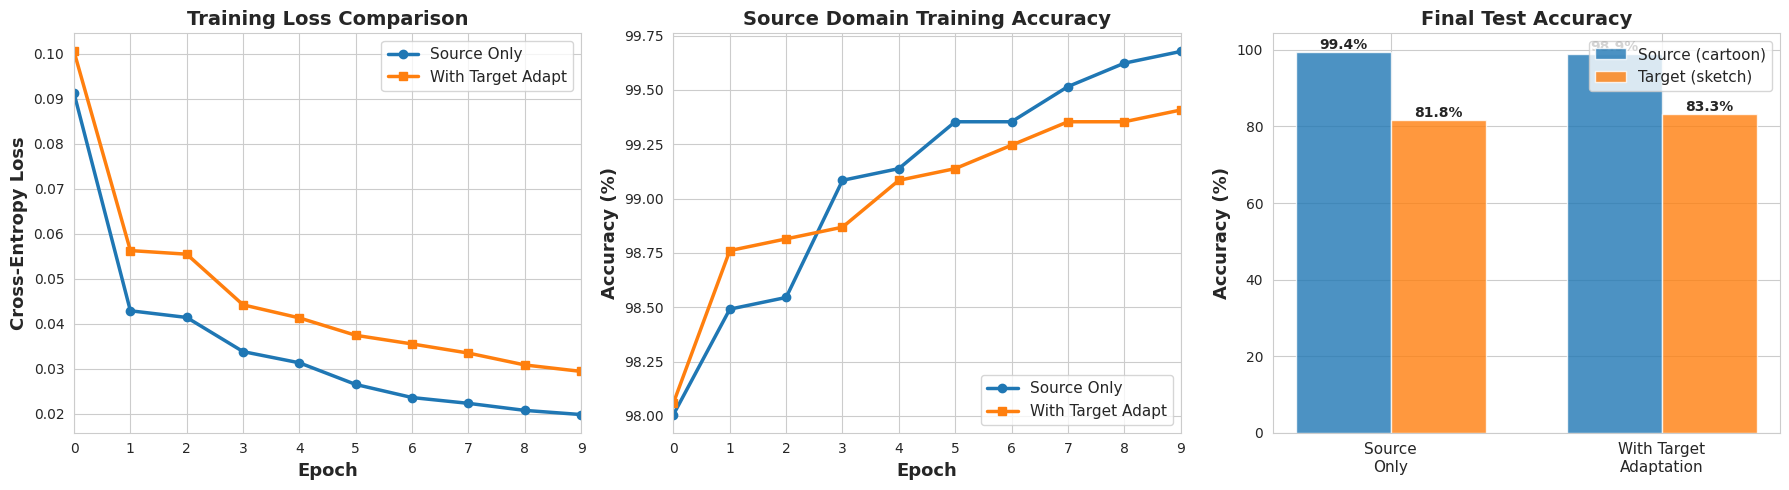


✓ Training curves saved as 'coop_training_comparison.png'


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np


fig, axes = plt.subplots(1, 3, figsize=(18, 5))

axes[0].plot(history_source_only['loss'], label='Source Only', linewidth=2.5, marker='o', markersize=6)
axes[0].plot(history_adapted['loss'], label='With Target Adapt', linewidth=2.5, marker='s', markersize=6)
axes[0].set_xlabel('Epoch', fontsize=13, fontweight='bold')
axes[0].set_ylabel('Cross-Entropy Loss', fontsize=13, fontweight='bold')
axes[0].set_title('Training Loss Comparison', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=11, loc='upper right')
axes[0].set_xlim(0, len(history_source_only['loss'])-1)

axes[1].plot(history_source_only['acc'], label='Source Only', linewidth=2.5, marker='o', markersize=6)
axes[1].plot(history_adapted['acc'], label='With Target Adapt', linewidth=2.5, marker='s', markersize=6)
axes[1].set_xlabel('Epoch', fontsize=13, fontweight='bold')
axes[1].set_ylabel('Accuracy (%)', fontsize=13, fontweight='bold')
axes[1].set_title('Source Domain Training Accuracy', fontsize=14, fontweight='bold')
axes[1].legend(fontsize=11, loc='lower right')
axes[1].set_xlim(0, len(history_source_only['acc'])-1)

methods = ['Source\nOnly', 'With Target\nAdaptation']
source_accs = [source_acc_only, source_acc_adapt]
target_accs = [target_acc_only, target_acc_adapt]

x = np.arange(len(methods))
width = 0.35

bars1 = axes[2].bar(x - width/2, source_accs, width, label=f'Source ({SOURCE_DOMAIN})', alpha=0.8)
bars2 = axes[2].bar(x + width/2, target_accs, width, label=f'Target ({TARGET_DOMAIN})', alpha=0.8)

axes[2].set_ylabel('Accuracy (%)', fontsize=13, fontweight='bold')
axes[2].set_title('Final Test Accuracy', fontsize=14, fontweight='bold')
axes[2].set_xticks(x)
axes[2].set_xticklabels(methods, fontsize=11)
axes[2].legend(fontsize=11)

for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        axes[2].text(bar.get_x() + bar.get_width()/2., height,
                    f'{height:.1f}%', ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.savefig('coop_training_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Training curves saved as 'coop_training_comparison.png'")

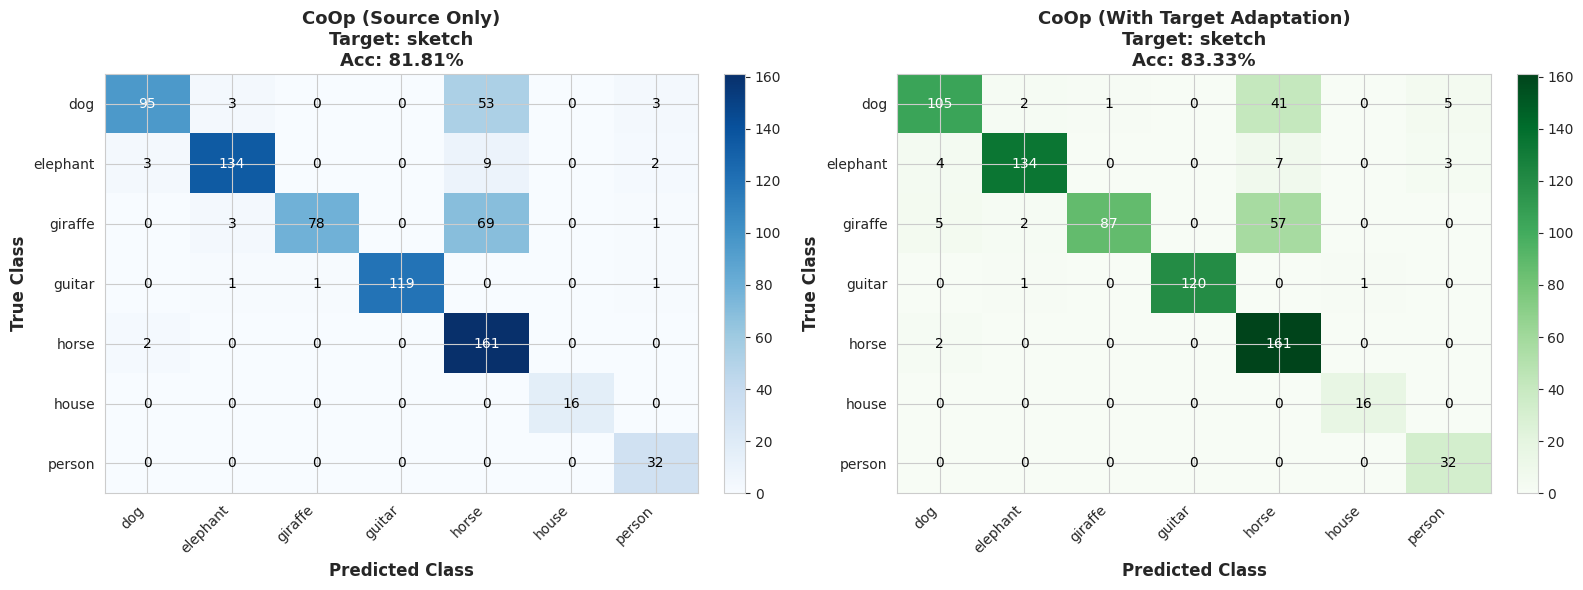


✓ Confusion matrices saved as 'coop_confusion_matrices.png'


In [ ]:
def get_confusion_matrix(model, loader, domain_name):
    """Get predictions and compute confusion matrix"""
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            outputs = model(images)
            _, predicted = outputs.max(1)

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.numpy())

    cm = confusion_matrix(all_labels, all_preds)
    return cm, all_preds, all_labels

cm_source_only, _, _ = get_confusion_matrix(coop_model, target_test_loader, TARGET_DOMAIN)
cm_adapted, _, _ = get_confusion_matrix(coop_model_adapt, target_test_loader, TARGET_DOMAIN)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

im1 = axes[0].imshow(cm_source_only, cmap='Blues', aspect='auto')
axes[0].set_title(f'CoOp (Source Only)\nTarget: {TARGET_DOMAIN}\nAcc: {target_acc_only:.2f}%',
                  fontsize=13, fontweight='bold')
axes[0].set_xlabel('Predicted Class', fontsize=12, fontweight='bold')
axes[0].set_ylabel('True Class', fontsize=12, fontweight='bold')
axes[0].set_xticks(range(len(class_names)))
axes[0].set_yticks(range(len(class_names)))
axes[0].set_xticklabels(class_names, rotation=45, ha='right')
axes[0].set_yticklabels(class_names)

for i in range(len(class_names)):
    for j in range(len(class_names)):
        text = axes[0].text(j, i, cm_source_only[i, j],
                           ha="center", va="center", color="white" if cm_source_only[i, j] > cm_source_only.max()/2 else "black")

plt.colorbar(im1, ax=axes[0], fraction=0.046, pad=0.04)

im2 = axes[1].imshow(cm_adapted, cmap='Greens', aspect='auto')
axes[1].set_title(f'CoOp (With Target Adaptation)\nTarget: {TARGET_DOMAIN}\nAcc: {target_acc_adapt:.2f}%',
                  fontsize=13, fontweight='bold')
axes[1].set_xlabel('Predicted Class', fontsize=12, fontweight='bold')
axes[1].set_ylabel('True Class', fontsize=12, fontweight='bold')
axes[1].set_xticks(range(len(class_names)))
axes[1].set_yticks(range(len(class_names)))
axes[1].set_xticklabels(class_names, rotation=45, ha='right')
axes[1].set_yticklabels(class_names)

for i in range(len(class_names)):
    for j in range(len(class_names)):
        text = axes[1].text(j, i, cm_adapted[i, j],
                           ha="center", va="center", color="white" if cm_adapted[i, j] > cm_adapted.max()/2 else "black")

plt.colorbar(im2, ax=axes[1], fraction=0.046, pad=0.04)

plt.tight_layout()
plt.savefig('coop_confusion_matrices.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Confusion matrices saved as 'coop_confusion_matrices.png'")

In [ ]:
# VISUALIZATION 5: Learned Prompt Analysis

def visualize_learned_prompts(model, model_name="CoOp"):
    """Analyze and visualize the learned prompt embeddings"""
    print(f"\n{'='*70}")
    print(f"LEARNED PROMPT ANALYSIS: {model_name}")
    print(f"{'='*70}\n")

    ctx = model.prompt_learner.ctx.data.cpu()

    print(f"Context Tensor Information:")
    print(f"  Shape: {ctx.shape}")
    print(f"  Number of learnable tokens: {ctx.shape[0]}")
    print(f"  Embedding dimension: {ctx.shape[1]}")
    print(f"  Data type: {ctx.dtype}")

    # Statistical analysis
    print(f"\nContext Vector Statistics:")
    print(f"  Mean: {ctx.mean().item():.6f}")
    print(f"  Std: {ctx.std().item():.6f}")
    print(f"  Min: {ctx.min().item():.6f}")
    print(f"  Max: {ctx.max().item():.6f}")

    ctx_norms = torch.norm(ctx, dim=1)
    print(f"\nPer-Token L2 Norms:")
    print(f"  Mean norm: {ctx_norms.mean().item():.4f}")
    print(f"  Std norm: {ctx_norms.std().item():.4f}")
    print(f"  Min norm: {ctx_norms.min().item():.4f}")
    print(f"  Max norm: {ctx_norms.max().item():.4f}")

    print(f"\nToken-wise Statistics:")
    for i in range(min(5, ctx.shape[0])):
        print(f"  Token {i+1}: norm={ctx_norms[i].item():.4f}, mean={ctx[i].mean().item():.6f}, std={ctx[i].std().item():.6f}")
    if ctx.shape[0] > 5:
        print(f"  ... ({ctx.shape[0] - 5} more tokens)")

    print(f"\nPrompt Structure:")
    print(f"  Template: [SOS] + [V1 V2 ... V{ctx.shape[0]}] + [CLASS] + [EOS]")
    print(f"  Example for 'dog': [SOS] [Context × {ctx.shape[0]}] dog . [EOS]")

    return ctx, ctx_norms


def compare_prompt_embeddings(model1, model2, name1="Model 1", name2="Model 2"):

    print(f"\n{'='*70}")
    print(f"PROMPT COMPARISON: {name1} vs {name2}")
    print(f"{'='*70}\n")

    ctx1 = model1.prompt_learner.ctx.data.cpu()
    ctx2 = model2.prompt_learner.ctx.data.cpu()

    ctx_diff = (ctx1 - ctx2).abs()

    print(f"Absolute Difference Statistics:")
    print(f"  Mean difference: {ctx_diff.mean().item():.6f}")
    print(f"  Max difference: {ctx_diff.max().item():.6f}")
    print(f"  Min difference: {ctx_diff.min().item():.6f}")

    ctx1_flat = ctx1.flatten()
    ctx2_flat = ctx2.flatten()
    cosine_sim = F.cosine_similarity(ctx1_flat.unsqueeze(0), ctx2_flat.unsqueeze(0))

    print(f"\nOverall Cosine Similarity: {cosine_sim.item():.4f}")

    token_sims = []
    for i in range(ctx1.shape[0]):
        sim = F.cosine_similarity(ctx1[i].unsqueeze(0), ctx2[i].unsqueeze(0))
        token_sims.append(sim.item())

    print(f"\nToken-wise Cosine Similarities:")
    print(f"  Mean: {np.mean(token_sims):.4f}")
    print(f"  Std: {np.std(token_sims):.4f}")
    print(f"  Min: {np.min(token_sims):.4f}")
    print(f"  Max: {np.max(token_sims):.4f}")

    return ctx_diff, token_sims


# Analyze both models
ctx_source_only, norms_source_only = visualize_learned_prompts(coop_model, "CoOp (Source Only)")
ctx_adapted, norms_adapted = visualize_learned_prompts(coop_model_adapt, "CoOp (With Target Adaptation)")


LEARNED PROMPT ANALYSIS: CoOp (Source Only)

Context Tensor Information:
  Shape: torch.Size([16, 512])
  Number of learnable tokens: 16
  Embedding dimension: 512
  Data type: torch.float32

Context Vector Statistics:
  Mean: -0.000291
  Std: 0.035500
  Min: -1.064820
  Max: 0.489660

Per-Token L2 Norms:
  Mean norm: 0.6785
  Std norm: 0.4441
  Min norm: 0.4692
  Max norm: 2.3001

Token-wise Statistics:
  Token 1: norm=0.8642, mean=0.001177, std=0.038210
  Token 2: norm=2.3001, mean=-0.000188, std=0.101749
  Token 3: norm=0.7081, mean=-0.000721, std=0.031314
  Token 4: norm=0.5338, mean=-0.000122, std=0.023616
  Token 5: norm=0.5133, mean=-0.000020, std=0.022707
  ... (11 more tokens)

Prompt Structure:
  Template: [SOS] + [V1 V2 ... V16] + [CLASS] + [EOS]
  Example for 'dog': [SOS] [Context × 16] dog . [EOS]

LEARNED PROMPT ANALYSIS: CoOp (With Target Adaptation)

Context Tensor Information:
  Shape: torch.Size([16, 512])
  Number of learnable tokens: 16
  Embedding dimension: 512
 

### Testing Brittleness

In [ ]:
import torch

# Suppose you have two .pth files saved:
prompt_path_1 = "coop_model_adapt_prompt_learner.pth"
prompt_path_2 = "coop_model_prompt_learner.pth"

# Load CLIP backbone (frozen) first
import clip
clip_model, preprocess = clip.load("ViT-B/32", device="cuda")

classnames = ["dog", "cat", "car", "bicycle", "person", "tree", "house"]  # example

# Create two separate CustomCLIP instances
model_1 = CustomCLIP(classnames, clip_model, n_ctx=16).to("cuda")
model_2 = CustomCLIP(classnames, clip_model, n_ctx=16).to("cuda")

# Load the saved learned prompt states
state_1 = torch.load(prompt_path_1, map_location="cuda")
state_2 = torch.load(prompt_path_2, map_location="cuda")

# Assuming you saved only the `prompt_learner` state dict
model_1.prompt_learner.load_state_dict(state_1)
model_2.prompt_learner.load_state_dict(state_2)

model_1.eval()
model_2.eval()


100%|███████████████████████████████████████| 338M/338M [01:28<00:00, 4.01MiB/s]


Initial context: "X X X X X X X X X X X X X X X X"
Number of context words (tokens): 16
Initial context: "X X X X X X X X X X X X X X X X"
Number of context words (tokens): 16


CustomCLIP(
  (prompt_learner): PromptLearner()
  (image_encoder): VisionTransformer(
    (conv1): Conv2d(3, 768, kernel_size=(32, 32), stride=(32, 32), bias=False)
    (ln_pre): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (transformer): Transformer(
      (resblocks): Sequential(
        (0): ResidualAttentionBlock(
          (attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
          )
          (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (mlp): Sequential(
            (c_fc): Linear(in_features=768, out_features=3072, bias=True)
            (gelu): QuickGELU()
            (c_proj): Linear(in_features=3072, out_features=768, bias=True)
          )
          (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        )
        (1): ResidualAttentionBlock(
          (attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_feat

In [ ]:
from torch.utils.data import DataLoader

# Example dataloader
test_loader = DataLoader(cartoon_test, batch_size=32, shuffle=False)

def evaluate_clip_prompts(model, loader):
    model.eval()
    correct, total = 0, 0
    for images, labels in loader:
        images, labels = images.cuda(), labels.cuda()
        with torch.no_grad():
            logits = model(images)
            preds = logits.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
    return 100.0 * correct / total

acc_1 = evaluate_clip_prompts(model_1, test_loader)
acc_2 = evaluate_clip_prompts(model_2, test_loader)

print(f"Prompt 1 Accuracy: {acc_1:.2f}%")
print(f"Prompt 2 Accuracy: {acc_2:.2f}%")


Prompt 1 Accuracy: 98.93%
Prompt 2 Accuracy: 98.51%


In [ ]:
def prediction_disagreement(model_a, model_b, loader):
    disagreements = 0
    total = 0
    for images, _ in loader:
        images = images.cuda()
        with torch.no_grad():
            logits_a = model_a(images)
            logits_b = model_b(images)
            preds_a = logits_a.argmax(dim=1)
            preds_b = logits_b.argmax(dim=1)
            disagreements += (preds_a != preds_b).sum().item()
            total += images.size(0)
    return disagreements / total * 100

disagreement_pct = prediction_disagreement(model_1, model_2, test_loader)
print(f"Prediction disagreement between prompts: {disagreement_pct:.2f}%")

Prediction disagreement between prompts: 0.85%


In [ ]:
from torch.utils.data import DataLoader

# Example dataloader
test_loader = DataLoader(sketch_test, batch_size=32, shuffle=False)

def evaluate_clip_prompts(model, loader):
    model.eval()
    correct, total = 0, 0
    for images, labels in loader:
        images, labels = images.cuda(), labels.cuda()
        with torch.no_grad():
            logits = model(images)
            preds = logits.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
    return 100.0 * correct / total

acc_1 = evaluate_clip_prompts(model_1, test_loader)
acc_2 = evaluate_clip_prompts(model_2, test_loader)

print(f"Prompt 1 Accuracy: {acc_1:.2f}%")
print(f"Prompt 2 Accuracy: {acc_2:.2f}%")


Prompt 1 Accuracy: 83.59%
Prompt 2 Accuracy: 80.79%


In [ ]:
def prediction_disagreement(model_a, model_b, loader):
    disagreements = 0
    total = 0
    for images, _ in loader:
        images = images.cuda()
        with torch.no_grad():
            logits_a = model_a(images)
            logits_b = model_b(images)
            preds_a = logits_a.argmax(dim=1)
            preds_b = logits_b.argmax(dim=1)
            disagreements += (preds_a != preds_b).sum().item()
            total += images.size(0)
    return disagreements / total * 100

disagreement_pct = prediction_disagreement(model_1, model_2, test_loader)
print(f"Prediction disagreement between prompts: {disagreement_pct:.2f}%")

Prediction disagreement between prompts: 5.09%


## Task 3.3: Gradient Conflict and Alignment (with 2 Source Domains)

In [ ]:
def evaluate_model(model, test_loader, domain_name="Test"):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            _, predicted = outputs.max(1)

            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    accuracy = 100. * correct / total
    print(f"{domain_name}: {accuracy:.2f}% ({correct}/{total})")

    return accuracy

In [ ]:
SOURCE_DOMAIN = 'art_painting'
TARGET_DOMAIN = 'sketch'

print(f"Source Domain: {SOURCE_DOMAIN}")
print(f"Target Domain: {TARGET_DOMAIN}")

source_train_loader = domain_loaders[SOURCE_DOMAIN]['train']
source_test_loader = domain_loaders[SOURCE_DOMAIN]['test']
target_train_loader = domain_loaders[TARGET_DOMAIN]['train']
target_test_loader = domain_loaders[TARGET_DOMAIN]['test']

print(f"\nData Loaders:")
print(f"  Source train batches: {len(source_train_loader)}")
print(f"  Source test batches: {len(source_test_loader)}")
print(f"  Target train batches: {len(target_train_loader)}")
print(f"  Target test batches: {len(target_test_loader)}")

Source Domain: art_painting
Target Domain: sketch

Data Loaders:
  Source train batches: 51
  Source test batches: 13
  Target train batches: 98
  Target test batches: 25


In [ ]:
def train_coop_with_gradcos(model, source_loader_a, source_loader_b,
                                        n_epochs=10, lr=0.002):

    optimizer = torch.optim.SGD(model.prompt_learner.parameters(), lr=lr, momentum=0.9)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, n_epochs)

    for name, param in model.named_parameters():
        param.requires_grad_(("prompt_learner" in name))

    history = {
        'loss': [], 'acc': [], 'source_loss_a': [], 'source_loss_b': [],
        'grad_cosine': []
    }

    iter_a = iter(source_loader_a)
    iter_b = iter(source_loader_b)

    for epoch in range(n_epochs):
        model.train()
        total_loss = total_loss_a = total_loss_b = 0
        correct = total = 0
        grad_cos_list = []


        steps_per_epoch = min(len(source_loader_a), len(source_loader_b))


        pbar = tqdm(range(steps_per_epoch), desc=f"Epoch {epoch+1}/{n_epochs}", leave=False)

        for _ in pbar:
            try:
                imgs_a, labels_a = next(iter_a)
            except StopIteration:
                iter_a = iter(source_loader_a)
                imgs_a, labels_a = next(iter_a)
            try:
                imgs_b, labels_b = next(iter_b)
            except StopIteration:
                iter_b = iter(source_loader_b)
                imgs_b, labels_b = next(iter_b)

            imgs_a, labels_a = imgs_a.to(device), labels_a.to(device)
            imgs_b, labels_b = imgs_b.to(device), labels_b.to(device)

            # --- Forward source A ---
            output_a = model(imgs_a)
            loss_a = F.cross_entropy(output_a, labels_a)
            total_loss_a += loss_a.item()

            # --- Forward source B ---
            output_b = model(imgs_b)
            loss_b = F.cross_entropy(output_b, labels_b)
            total_loss_b += loss_b.item()

            # --- Compute gradient cosine ---
            grads_a = torch.autograd.grad(loss_a, model.prompt_learner.parameters(), retain_graph=True)
            grads_b = torch.autograd.grad(loss_b, model.prompt_learner.parameters(), retain_graph=True)
            g1 = torch.cat([g.flatten() for g in grads_a])
            g2 = torch.cat([g.flatten() for g in grads_b])
            grad_cos = F.cosine_similarity(g1.unsqueeze(0), g2.unsqueeze(0)).item()
            grad_cos_list.append(grad_cos)

            # --- Total loss & update ---
            optimizer.zero_grad()
            (loss_a + loss_b).backward()
            optimizer.step()

            total_loss += (loss_a + loss_b).item()
            _, predicted = output_a.max(1)  # evaluate on source A batch
            total += labels_a.size(0)
            correct += predicted.eq(labels_a).sum().item()

            pbar.set_postfix({'loss': f'{loss_a.item()+loss_b.item():.4f}',
                              'acc': f'{100.*correct/total:.2f}%',
                              'grad_cos': f'{grad_cos:.3f}'})

        # --- Epoch metrics ---
        avg_loss = total_loss / len(pbar)
        avg_loss_a = total_loss_a / len(pbar)
        avg_loss_b = total_loss_b / len(pbar)
        mean_grad_cos = np.mean(grad_cos_list)
        epoch_acc = 100. * correct / total

        history['loss'].append(avg_loss)
        history['source_loss_a'].append(avg_loss_a)
        history['source_loss_b'].append(avg_loss_b)
        history['grad_cosine'].append(mean_grad_cos)

        print(f"Epoch {epoch+1}: Total Loss={avg_loss:.4f}, "
              f"Source A Acc={epoch_acc:.2f}%, Mean Grad Cos={mean_grad_cos:.4f}")

        scheduler.step()

    return history


In [ ]:
print(f"\n{'='*70}")
print("EXPERIMENT 3: CoOp with Pseudo-Label Target Adaptation to test Gradient Conflict")
print(f"{'='*70}")

clip_model_3, _ = clip.load("ViT-B/32", device=device)
clip_model_3.float()

coop_model_g = CustomCLIP(class_names, clip_model_3, n_ctx=16, ctx_init=None, class_token_position="end")
coop_model_g = coop_model_g.to(device)

source_train_loader2 = target_train_loader
source_test_loader2 = target_test_loader

history_adapted = train_coop_with_gradcos(
    coop_model_g,
    source_train_loader,
    source_train_loader2,
    n_epochs=5,
    lr=0.002,
)

print(f"\n{'='*70}")
print("EVALUATION: CoOp")
print(f"{'='*70}\n")

source_acc_g = evaluate_model(coop_model_g, source_test_loader, f"Source ({SOURCE_DOMAIN})")
source2_acc_g = evaluate_model(coop_model_g, source_test_loader2, f"Source 2 ({TARGET_DOMAIN})")


EXPERIMENT 3: CoOp with Pseudo-Label Target Adaptation to test Gradient Conflict
Initial context: "X X X X X X X X X X X X X X X X"
Number of context words (tokens): 16


Epoch 1: Total Loss=0.4308, Source A Acc=95.77%, Mean Grad Cos=0.0887


Epoch 2: Total Loss=0.3319, Source A Acc=97.37%, Mean Grad Cos=-0.0204


Epoch 3: Total Loss=0.3240, Source A Acc=97.43%, Mean Grad Cos=-0.0272


Epoch 4: Total Loss=0.3144, Source A Acc=97.49%, Mean Grad Cos=0.0344


Epoch 5: Total Loss=0.2678, Source A Acc=97.73%, Mean Grad Cos=-0.0096

EVALUATION: CoOp

Source (art_painting): 97.32% (399/410)
Source 2 (sketch): 91.09% (716/786)


In [ ]:
def train_coop_with_gradcos_and_proj(model, source_loader_a, source_loader_b,
                                     n_epochs=10, lr=0.002):
    """
    Train CoOp prompt learner on two source domains and apply GradCos projection to reduce gradient conflict.
    """
    optimizer = torch.optim.SGD(model.prompt_learner.parameters(), lr=lr, momentum=0.9)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, n_epochs)

    for name, param in model.named_parameters():
        param.requires_grad_(("prompt_learner" in name))

    history = {
        'loss': [], 'acc': [], 'source_loss_a': [], 'source_loss_b': [],
        'grad_cos_before': [], 'grad_cos_after': []
    }

    iter_a = iter(source_loader_a)
    iter_b = iter(source_loader_b)

    for epoch in range(n_epochs):
        model.train()
        total_loss = total_loss_a = total_loss_b = 0
        correct = total = 0
        grad_cos_before_list = []
        grad_cos_after_list = []

        steps_per_epoch = min(len(source_loader_a), len(source_loader_b))
        pbar = tqdm(range(steps_per_epoch), desc=f"Epoch {epoch+1}/{n_epochs}", leave=False)

        for _ in pbar:
            # --- Fetch batches ---
            try:
                imgs_a, labels_a = next(iter_a)
            except StopIteration:
                iter_a = iter(source_loader_a)
                imgs_a, labels_a = next(iter_a)
            try:
                imgs_b, labels_b = next(iter_b)
            except StopIteration:
                iter_b = iter(source_loader_b)
                imgs_b, labels_b = next(iter_b)

            imgs_a, labels_a = imgs_a.to(device), labels_a.to(device)
            imgs_b, labels_b = imgs_b.to(device), labels_b.to(device)

            # --- Compute individual losses ---
            output_a = model(imgs_a)
            loss_a = F.cross_entropy(output_a, labels_a)
            output_b = model(imgs_b)
            loss_b = F.cross_entropy(output_b, labels_b)

            total_loss_a += loss_a.item()
            total_loss_b += loss_b.item()

            # --- Compute individual gradients (prompt learner only) ---
            grads_a = torch.autograd.grad(loss_a, model.prompt_learner.parameters(), retain_graph=True)
            grads_b = torch.autograd.grad(loss_b, model.prompt_learner.parameters(), retain_graph=True)

            g1 = torch.cat([g.flatten() for g in grads_a])
            g2 = torch.cat([g.flatten() for g in grads_b])

            # --- Cosine similarity before GradCos ---
            cos_before = F.cosine_similarity(g1.unsqueeze(0), g2.unsqueeze(0)).item()
            grad_cos_before_list.append(cos_before)

            # --- GradCos projection ---
            # If cos < 0, project g2 to remove conflict
            if cos_before < 0:
                g2_proj = g2 - (torch.dot(g1, g2) / (g1.norm()**2)) * g1
            else:
                g2_proj = g2
            grad_cos_after = F.cosine_similarity(g1.unsqueeze(0), g2_proj.unsqueeze(0)).item()
            grad_cos_after_list.append(grad_cos_after)

            optimizer.zero_grad()
            start = 0
            for p, ga in zip(model.prompt_learner.parameters(), grads_a):
                n = ga.numel()
                p.grad = g1[start:start+n].view_as(ga).clone()
                start += n
            start = 0
            for p, gb_proj in zip(model.prompt_learner.parameters(), grads_b):
                n = gb_proj.numel()
                p.grad += g2_proj[start:start+n].view_as(gb_proj).clone()  # sum with g1
                start += n

            optimizer.step()

            total_loss += (loss_a + loss_b).item()
            _, predicted = output_a.max(1)  # eval on source A
            total += labels_a.size(0)
            correct += predicted.eq(labels_a).sum().item()

            pbar.set_postfix({
                'loss': f'{loss_a.item()+loss_b.item():.4f}',
                'acc': f'{100.*correct/total:.2f}%',
                'grad_cos_before': f'{cos_before:.3f}',
                'grad_cos_after': f'{grad_cos_after:.3f}'
            })

        avg_loss = total_loss / steps_per_epoch
        avg_loss_a = total_loss_a / steps_per_epoch
        avg_loss_b = total_loss_b / steps_per_epoch
        mean_cos_before = np.mean(grad_cos_before_list)
        mean_cos_after = np.mean(grad_cos_after_list)
        epoch_acc = 100. * correct / total

        history['loss'].append(avg_loss)
        history['source_loss_a'].append(avg_loss_a)
        history['source_loss_b'].append(avg_loss_b)
        history['grad_cos_before'].append(mean_cos_before)
        history['grad_cos_after'].append(mean_cos_after)

        print(f"Epoch {epoch+1}: Loss={avg_loss:.4f}, Source A Acc={epoch_acc:.2f}%, "
              f"Mean Grad Cos Before={mean_cos_before:.4f}, After={mean_cos_after:.4f}")

        scheduler.step()

    return history


In [ ]:
print(f"\n{'='*70}")
print("EXPERIMENT 4: CoOp with Pseudo-Label Target Adaptation to fix Gradient Conflict through GradCos")
print(f"{'='*70}")

clip_model_4, _ = clip.load("ViT-B/32", device=device)
clip_model_4.float()

coop_model_gc = CustomCLIP(class_names, clip_model_4, n_ctx=16, ctx_init=None, class_token_position="end")
coop_model_gc = coop_model_gc.to(device)

source_train_loader2 = target_train_loader
source_test_loader2 = target_test_loader

history_adapted = train_coop_with_gradcos_and_proj(
    coop_model_gc,
    source_train_loader,
    source_train_loader2,
    n_epochs=5,
    lr=0.002,
)

print(f"\n{'='*70}")
print("EVALUATION: CoOp")
print(f"{'='*70}\n")

source_acc_gc = evaluate_model(coop_model_gc, source_test_loader, f"Source ({SOURCE_DOMAIN})")
source2_acc_gc = evaluate_model(coop_model_gc, source_test_loader2, f"Source 2 ({TARGET_DOMAIN})")


EXPERIMENT 4: CoOp with Pseudo-Label Target Adaptation to fix Gradient Conflict through GradCos
Initial context: "X X X X X X X X X X X X X X X X"
Number of context words (tokens): 16


Epoch 1: Loss=0.4916, Source A Acc=95.71%, Mean Grad Cos Before=0.0817, After=0.1686


Epoch 2: Loss=0.3360, Source A Acc=97.30%, Mean Grad Cos Before=0.0589, After=0.1174


Epoch 3: Loss=0.3246, Source A Acc=97.37%, Mean Grad Cos Before=0.0509, After=0.1060


Epoch 4: Loss=0.2881, Source A Acc=98.10%, Mean Grad Cos Before=0.0448, After=0.1049


Epoch 5: Loss=0.2624, Source A Acc=98.35%, Mean Grad Cos Before=0.0141, After=0.0636

EVALUATION: CoOp

Source (art_painting): 96.83% (397/410)
Source 2 (sketch): 91.98% (723/786)


### Visualization

Gradient Cosine Examples (prompt learner):
  Negative: -0.3788
  Zero: -0.0365
  Positive: 0.1943


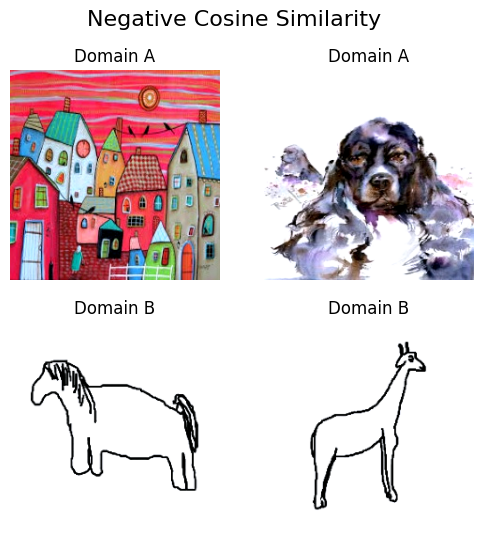

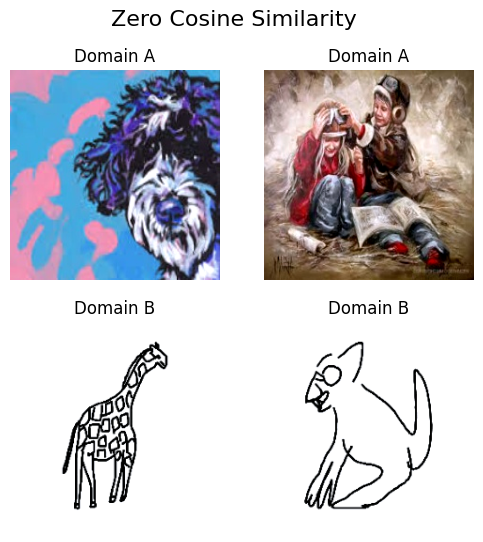

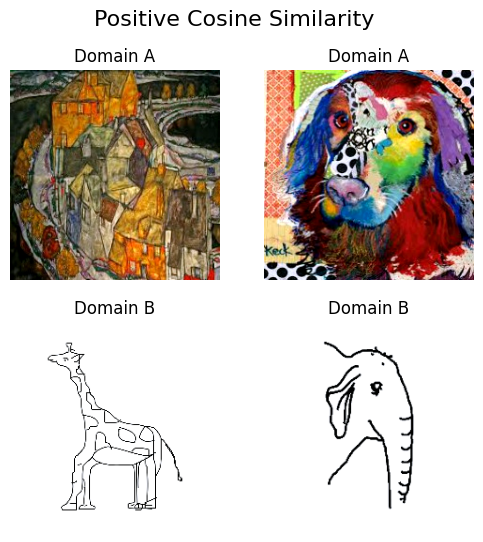

In [ ]:
import torch
import torch.nn.functional as F
from tqdm import tqdm
import matplotlib.pyplot as plt

def show_grad_cos_examples_with_images(model, loader_a, loader_b, pseudo_threshold=0.9, n_images=2):
    """
    Show examples of negative, zero, and positive cosine similarity between
    gradients for two domains (or source+target), along with images.
    """
    model.eval()
    examples = {'negative': None, 'zero': None, 'positive': None}
    images_examples = {'negative': None, 'zero': None, 'positive': None}

    iter_a = iter(loader_a)
    iter_b = iter(loader_b)

    while None in examples.values():  # stop once we find all three
        try:
            imgs_a, labels_a = next(iter_a)
        except StopIteration:
            iter_a = iter(loader_a)
            imgs_a, labels_a = next(iter_a)
        try:
            imgs_b, labels_b = next(iter_b)
        except StopIteration:
            iter_b = iter(loader_b)
            imgs_b, labels_b = next(iter_b)

        imgs_a, labels_a = imgs_a.to(device), labels_a.to(device)
        imgs_b, labels_b = imgs_b.to(device), labels_b.to(device)

        # --- Forward & gradient for domain A ---
        loss_a = F.cross_entropy(model(imgs_a), labels_a)
        grads_a = torch.autograd.grad(loss_a, model.prompt_learner.parameters(), retain_graph=True)

        # --- Forward & gradient for domain B ---
        loss_b = F.cross_entropy(model(imgs_b), labels_b)
        grads_b = torch.autograd.grad(loss_b, model.prompt_learner.parameters(), retain_graph=True)

        # --- Compute cosine similarity ---
        g1 = torch.cat([g.flatten() for g in grads_a])
        g2 = torch.cat([g.flatten() for g in grads_b])
        cos_sim = F.cosine_similarity(g1.unsqueeze(0), g2.unsqueeze(0)).item()

        # --- Store examples and corresponding images ---
        if cos_sim < 0 and examples['negative'] is None:
            examples['negative'] = cos_sim
            images_examples['negative'] = (imgs_a[:n_images].cpu(), imgs_b[:n_images].cpu())
        elif -0.05 <= cos_sim <= 0.05 and examples['zero'] is None:
            examples['zero'] = cos_sim
            images_examples['zero'] = (imgs_a[:n_images].cpu(), imgs_b[:n_images].cpu())
        elif cos_sim > 0 and examples['positive'] is None:
            examples['positive'] = cos_sim
            images_examples['positive'] = (imgs_a[:n_images].cpu(), imgs_b[:n_images].cpu())

    print("Gradient Cosine Examples (prompt learner):")
    for key in ['negative', 'zero', 'positive']:
        print(f"  {key.capitalize()}: {examples[key]:.4f}")

    return examples, images_examples

def visualize_grad_cos_images(images_examples, clip_min=0.0, clip_max=1.0, mean=[0.48145466, 0.4578275, 0.40821073], std=[0.26862954, 0.26130258, 0.27577711]):
    """
    Visualize the stored image pairs for negative, zero, and positive cosine similarity.
    Undo CLIP normalization and clip to [0,1] for display.
    """
    mean = torch.tensor(mean).view(3,1,1)
    std = torch.tensor(std).view(3,1,1)

    for key, (imgs_a, imgs_b) in images_examples.items():
        n = min(len(imgs_a), len(imgs_b))
        fig, axes = plt.subplots(2, n, figsize=(3*n, 6))
        fig.suptitle(f"{key.capitalize()} Cosine Similarity", fontsize=16)
        for i in range(n):
            # Unnormalize
            img_a = imgs_a[i] * std + mean
            img_b = imgs_b[i] * std + mean
            img_a = torch.clamp(img_a, clip_min, clip_max).permute(1,2,0).numpy()
            img_b = torch.clamp(img_b, clip_min, clip_max).permute(1,2,0).numpy()

            # Domain A images
            axes[0, i].imshow(img_a)
            axes[0, i].axis('off')
            axes[0, i].set_title("Domain A")
            # Domain B images
            axes[1, i].imshow(img_b)
            axes[1, i].axis('off')
            axes[1, i].set_title("Domain B")
        plt.show()


examples, images_examples = show_grad_cos_examples_with_images(coop_model_g, source_train_loader, source_train_loader2)
visualize_grad_cos_images(images_examples)


## Task 3.4: Open-set Adaptation


In [ ]:
class_names = photo_dataset.classes
print("Number of classes:", len(class_names))
print("Classes:", class_names)

Number of classes: 7
Classes: ['dog', 'elephant', 'giraffe', 'guitar', 'horse', 'house', 'person']


In [ ]:
from collections import defaultdict

def create_seen_unseen_split(class_names, seen_fraction=0.6, seed=42):
    n = len(class_names)
    n_seen = max(1, int(round(n * seen_fraction)))
    rng = np.random.RandomState(seed)
    perm = rng.permutation(n)
    seen_idx = sorted(perm[:n_seen].tolist())
    unseen_idx = sorted(perm[n_seen:].tolist())
    seen = [class_names[i] for i in seen_idx]
    unseen = [class_names[i] for i in unseen_idx]
    return seen, unseen, seen_idx, unseen_idx

seen_classes, unseen_classes, seen_indices, unseen_indices = create_seen_unseen_split(class_names, 0.7)
print("Seen classes ({}):".format(len(seen_classes)), seen_classes)
print("Unseen classes ({}):".format(len(unseen_classes)), unseen_classes)
print("Seen index:", seen_indices)
print("Unseen index:", unseen_indices)


Seen classes (5): ['dog', 'elephant', 'giraffe', 'horse', 'house']
Unseen classes (2): ['guitar', 'person']
Seen index: [0, 1, 2, 4, 5]
Unseen index: [3, 6]


In [ ]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset

domain = "photo"

data_root = f"./Homework3-PACS/PACS/{domain}"

transf = transforms.Compose([
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize((0.485,0.456,0.406), (0.229,0.224,0.225))
])

dataset = datasets.ImageFolder(data_root, transform=transf)

# ---- Split dataset by seen/unseen ----
seen_ids = [i for i, (_, y) in enumerate(dataset.samples) if y in seen_indices]
unseen_ids = [i for i, (_, y) in enumerate(dataset.samples) if y in unseen_indices]

train_dataset = Subset(dataset, seen_ids)
test_dataset = dataset  # includes both seen + unseen

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


In [ ]:
import torch
import clip
import torch.nn.functional as F

device = "cuda" if torch.cuda.is_available() else "cpu"
clip_model, preprocess = clip.load("ViT-B/32", device=device)

def get_text_features(class_names):
    texts = [f"a photo of a {c}" for c in class_names]
    text_tokens = clip.tokenize(texts).to(device)
    with torch.no_grad():
        text_features = clip_model.encode_text(text_tokens)
        text_features /= text_features.norm(dim=-1, keepdim=True)
    return text_features

text_features_all = get_text_features(all_classes)
text_features_seen = get_text_features(seen_classes)
text_features_unseen = get_text_features(unseen_classes)

def evaluate_clip(loader):
    correct_seen = correct_unseen = total_seen = total_unseen = 0
    msp_scores = []

    with torch.no_grad():
        for imgs, labels in loader:
            imgs, labels = imgs.to(device), labels.to(device)
            image_features = clip_model.encode_image(imgs)
            image_features /= image_features.norm(dim=-1, keepdim=True)

            logits = image_features @ text_features_all.T
            probs = logits.softmax(dim=-1)
            msp = probs.max(dim=-1).values
            msp_scores.extend(msp.cpu().numpy())

            preds = probs.argmax(dim=-1)
            for y, p in zip(labels, preds):
                if y.item() in seen_indices:
                    total_seen += 1
                    correct_seen += (y == p).item()
                else:
                    total_unseen += 1
                    correct_unseen += (y == p).item()

    acc_seen = correct_seen / total_seen * 100
    acc_unseen = correct_unseen / total_unseen * 100
    avg_msp = sum(msp_scores) / len(msp_scores)

    print(f"Zero-Shot CLIP | Seen Accuracy: {acc_seen:.2f}% | Unseen Accuracy: {acc_unseen:.2f}% | Avg MSP: {avg_msp:.3f}")


In [ ]:
evaluate_clip(test_loader)

Zero-Shot CLIP | Seen Accuracy: 99.33% | Unseen Accuracy: 100.00% | Avg MSP: 0.135


In [ ]:
def train_coop_official_seen(
    model,
    train_loader,
    seen_indices=None,        # NEW: which class labels are allowed
    target_loader=None,
    n_epochs=50,
    lr=0.002,
    use_target=False,
    target_weight=1.0,
    pseudo_threshold=0.9
):
    optimizer = torch.optim.SGD(model.prompt_learner.parameters(), lr=lr, momentum=0.9)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, n_epochs)

    print("Turning off gradients in both the image and text encoder")
    for name, param in model.named_parameters():
        if "prompt_learner" not in name:
            param.requires_grad_(False)

    print(f"\nTraining Configuration:")
    print(f"  Epochs: {n_epochs}")
    print(f"  Learning rate: {lr}")
    print(f"  Optimizer: SGD with momentum=0.9")
    print(f"  Use target: {use_target}")
    if use_target:
        print(f"  Adaptation method: Pseudo-labeling")
        print(f"  Confidence threshold: {pseudo_threshold}")
        print(f"  Target weight: {target_weight}")

    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"  Trainable parameters: {trainable_params}")

    history = {
        'loss': [],
        'acc': [],
        'source_loss': [],
        'target_loss': [],
        'pseudo_label_ratio': []
    }

    if use_target and target_loader:
        target_iter = iter(target_loader)

    for epoch in range(n_epochs):
        model.train()

        total_loss = 0
        total_source_loss = 0
        total_target_loss = 0
        correct = 0
        total = 0
        total_pseudo_samples = 0
        total_target_samples = 0

        pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{n_epochs}", leave=False)

        for batch_idx, (images, labels) in enumerate(pbar):
            images, labels = images.to(device), labels.to(device)

            # === OPEN-SET FIX ===
            if seen_indices is not None:
                mask = torch.tensor([int(l.item() in seen_indices) for l in labels], device=device, dtype=torch.bool)
                if not mask.any():
                    continue
                images, labels = images[mask], labels[mask]

            # --- Forward and compute source loss ---
            output = model(images)
            source_loss = F.cross_entropy(output, labels)
            loss = source_loss
            total_source_loss += source_loss.item()

            target_loss_value = 0
            if use_target and target_loader:
                try:
                    target_images, _ = next(target_iter)
                except StopIteration:
                    target_iter = iter(target_loader)
                    target_images, _ = next(target_iter)

                target_images = target_images.to(device)
                target_output = model(target_images)

                target_probs = F.softmax(target_output, dim=-1)
                max_probs, pseudo_labels = target_probs.max(dim=1)
                confident_mask = max_probs >= pseudo_threshold

                if confident_mask.sum() > 0:
                    target_loss = F.cross_entropy(
                        target_output[confident_mask],
                        pseudo_labels[confident_mask]
                    )
                    loss = loss + target_weight * target_loss
                    target_loss_value = target_loss.item()
                    total_pseudo_samples += confident_mask.sum().item()

                total_target_samples += target_images.size(0)
                total_target_loss += target_loss_value

            # --- Backprop ---
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            _, predicted = output.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

            acc = 100. * correct / total
            if use_target and total_target_samples > 0:
                pseudo_ratio = 100. * total_pseudo_samples / total_target_samples
                pbar.set_postfix({
                    'loss': f'{loss.item():.4f}',
                    'acc': f'{acc:.2f}%',
                    'pseudo': f'{pseudo_ratio:.1f}%'
                })
            else:
                pbar.set_postfix({'loss': f'{loss.item():.4f}', 'acc': f'{acc:.2f}%'})

        scheduler.step()

        avg_loss = total_loss / len(train_loader)
        avg_source_loss = total_source_loss / len(train_loader)
        avg_target_loss = total_target_loss / len(train_loader) if use_target else 0
        epoch_acc = 100. * correct / total
        pseudo_label_ratio = (
            100. * total_pseudo_samples / total_target_samples
            if total_target_samples > 0 else 0
        )

        history['loss'].append(avg_loss)
        history['acc'].append(epoch_acc)
        history['source_loss'].append(avg_source_loss)
        history['target_loss'].append(avg_target_loss)
        history['pseudo_label_ratio'].append(pseudo_label_ratio)

        if (epoch + 1) % 10 == 0 or epoch == 0:
            print(f"\nEpoch {epoch+1}/{n_epochs}:")
            print(f"  Total Loss: {avg_loss:.4f} | Source Loss: {avg_source_loss:.4f}", end="")
            if use_target:
                print(f" | Target Loss: {avg_target_loss:.4f}")
                print(f"  Source Acc: {epoch_acc:.2f}% | Pseudo-labels used: {pseudo_label_ratio:.1f}%")
            else:
                print(f" | Source Acc: {epoch_acc:.2f}%")

    return history


def evaluate_model(model, test_loader, seen_indices, unseen_indices, domain_name="Test"):
    model.eval()
    correct_seen = correct_unseen = total_seen = total_unseen = 0
    msp_scores = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            probs = F.softmax(outputs, dim=-1)
            preds = probs.argmax(dim=-1)
            msp = probs.max(dim=-1).values
            msp_scores.extend(msp.cpu().numpy())

            for y, p in zip(labels, preds):
                if y.item() in seen_indices:
                    total_seen += 1
                    correct_seen += (y == p).item()
                elif y.item() in unseen_indices:
                    total_unseen += 1
                    correct_unseen += (y == p).item()

    acc_seen = correct_seen / total_seen * 100 if total_seen > 0 else 0
    acc_unseen = correct_unseen / total_unseen * 100 if total_unseen > 0 else 0
    avg_msp = sum(msp_scores) / len(msp_scores)

    print(f"\n{domain_name} Evaluation:")
    print(f"  Seen Acc: {acc_seen:.2f}% | Unseen Acc: {acc_unseen:.2f}% | Avg MSP: {avg_msp:.3f}")

    return acc_seen, acc_unseen, avg_msp

In [ ]:
clip_model_2, _ = clip.load("ViT-B/32", device=device)
clip_model_2.float()

coop_model_seen = CustomCLIP(class_names, clip_model_2, n_ctx=16, ctx_init=None, class_token_position="end")
coop_model_seen = coop_model_seen.to(device)

history_seen = train_coop_official_seen(
    coop_model_seen,
    train_loader=train_loader,
    target_loader=None,
    seen_indices=seen_indices,
    n_epochs=10,
    lr=0.002,
    use_target=False,
)


Initial context: "X X X X X X X X X X X X X X X X"
Number of context words (tokens): 16
Turning off gradients in both the image and text encoder

Training Configuration:
  Epochs: 10
  Learning rate: 0.002
  Optimizer: SGD with momentum=0.9
  Use target: False
  Trainable parameters: 8192



Epoch 1/10:
  Total Loss: 0.0257 | Source Loss: 0.0257 | Source Acc: 99.52%



Epoch 10/10:
  Total Loss: 0.0017 | Source Loss: 0.0017 | Source Acc: 100.00%


In [ ]:
acc_seen, acc_unseen, avg_msp = evaluate_model(coop_model_seen, test_loader, seen_indices, unseen_indices, domain_name="Test")


Test Evaluation:
  Seen Acc: 100.00% | Unseen Acc: 86.73% | Avg MSP: 0.919


In [ ]:
import torch
import numpy as np
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
import torch.nn.functional as F

@torch.no_grad()
def analyze_open_set_msp(model, test_loader, seen_class_ids, text_features=None, device="cuda", plot_hist=True):
    """
    Evaluate open-set calibration via Maximum Softmax Probability (MSP).

    Args:
        model: CLIP or CoOp model (must output logits per class)
        test_loader: DataLoader with mixed seen/unseen samples
        seen_class_ids: list or set of seen class indices
        text_features: optional tensor of text features (for CLIP zero-shot)
        device: device for inference
        plot_hist: whether to show histogram plots

    Returns:
        dict with seen/unseen accuracy, MSP stats, AUROC, FPR@0.5
    """
    model.eval()

    msp_seen, msp_unseen = [], []
    correct_seen, correct_unseen = [], []

    for imgs, labels in test_loader:
        imgs, labels = imgs.to(device), labels.to(device)

        # --- Forward pass ---
        if text_features is not None:
            # Zero-shot CLIP case
            image_features = model.encode_image(imgs)
            image_features /= image_features.norm(dim=-1, keepdim=True)
            logits = 100 * image_features @ text_features.T
        else:
            # CoOp case
            logits = model(imgs)

        probs = F.softmax(logits, dim=-1)
        preds = probs.argmax(dim=-1)
        msp_batch = probs.max(dim=-1).values

        # --- Split seen vs unseen ---
        for p, l, m in zip(preds, labels, msp_batch):
            if l.item() in seen_class_ids:
                msp_seen.append(m.item())
                correct_seen.append(int(p == l))
            else:
                msp_unseen.append(m.item())
                correct_unseen.append(int(p == l))

    # --- Compute stats ---
    seen_acc = 100 * np.mean(correct_seen) if len(correct_seen) > 0 else 0
    unseen_acc = 100 * np.mean(correct_unseen) if len(correct_unseen) > 0 else 0
    avg_msp_seen = np.mean(msp_seen)
    avg_msp_unseen = np.mean(msp_unseen)
    fpr_unseen = np.mean(np.array(msp_unseen) > 0.5)

    # AUROC for open-set detection
    labels_binary = np.concatenate([np.ones(len(msp_seen)), np.zeros(len(msp_unseen))])
    msp_all = np.concatenate([msp_seen, msp_unseen])
    auroc = roc_auc_score(labels_binary, msp_all) if len(np.unique(labels_binary)) > 1 else float('nan')

    # --- Optional histogram plot ---
    if plot_hist:
        plt.figure(figsize=(6,4))
        plt.hist(msp_seen, bins=40, alpha=0.6, label='Seen')
        plt.hist(msp_unseen, bins=40, alpha=0.6, label='Unseen')
        plt.xlabel("Maximum Softmax Probability")
        plt.ylabel("Count")
        plt.legend()
        plt.title("MSP Distribution for Zero-Shot CLIP (Seen vs Unseen)")
        plt.show()

    # --- Print summary ---
    print(f"\nOpen-Set MSP Analysis:")
    print(f"  Seen Acc:   {seen_acc:.2f}% | Avg MSP: {avg_msp_seen:.3f}")
    print(f"  Unseen Acc: {unseen_acc:.2f}% | Avg MSP: {avg_msp_unseen:.3f}")
    print(f"  AUROC (Seen vs Unseen MSP): {auroc:.3f}")
    print(f"  FPR@0.5 on Unseen: {fpr_unseen:.3f}")

    return {
        'seen_acc': seen_acc,
        'unseen_acc': unseen_acc,
        'avg_msp_seen': avg_msp_seen,
        'avg_msp_unseen': avg_msp_unseen,
        'auroc': auroc,
        'fpr_unseen': fpr_unseen
    }


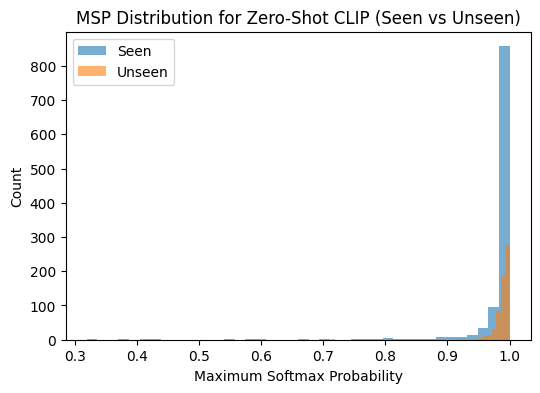


Open-Set MSP Analysis:
  Seen Acc:   99.33% | Avg MSP: 0.983
  Unseen Acc: 100.00% | Avg MSP: 0.988
  AUROC (Seen vs Unseen MSP): 0.648
  FPR@0.5 on Unseen: 1.000


In [ ]:
prompts = [f"a photo of a {c}" for c in class_names]

with torch.no_grad():
    text_tokens = clip.tokenize(prompts).to(device)
    text_features = clip_model.encode_text(text_tokens)
    text_features /= text_features.norm(dim=-1, keepdim=True)

clip_model.eval()
results_clip = analyze_open_set_msp(
    model=clip_model,
    test_loader=test_loader,
    seen_class_ids=seen_indices,
    text_features=text_features,   # precomputed CLIP text embeddings
    device=device
)

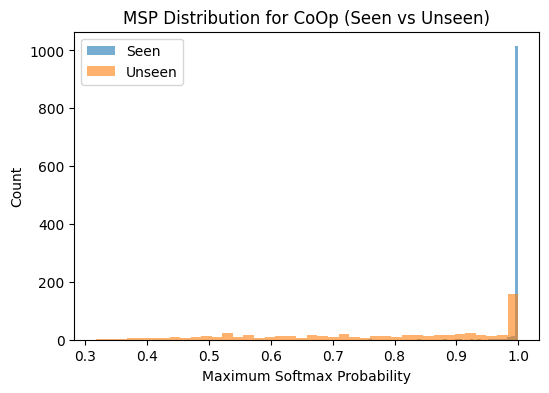


Open-Set MSP Analysis:
  Seen Acc:   100.00% | Avg MSP: 0.998
  Unseen Acc: 86.73% | Avg MSP: 0.785
  AUROC (Seen vs Unseen MSP): 0.987
  FPR@0.5 on Unseen: 0.896


In [ ]:
results_coop = analyze_open_set_msp(
    model=coop_model_seen,
    test_loader=test_loader,
    seen_class_ids=seen_indices,
    device=device
)